# Часть 1. Фильтрация данных

---

Задание, которое в форме для ДЗ - из исходной таблицы требуется удалить строки данных, содержащие попуски, NaN, прочерки и т.д. Столбец Date разделить на три столбца (день, месяц, год), аналогично поступить со столбцом Time (минуты, секунды). Данные в столбце wind_speed_2 оставить только в м/с. В остальных столбцах оставить только числовые данные без лишних символов.

---

После выполнения работы был замечены некоторые недостатки исходной таблицы:

1. Показания влажности отрицательные;
2. В некоторых ячейках отсутсвует показание в м/с;
3. Была другая задача с исходной таблицей (в задании надо было разделить два стоблца Date и Time, а в таблице всё находилось в столбце Date);
4. При загрузки таблицы в Colab проценты перевелись в числовое соотношение процента от 0 до 1.

Данные недостатки были учтены в данном коде.

---

In [ ]:
# Для использования данных из Drive
from google.colab import drive

#Для работы с данными
import pandas as pd
import numpy as np

#Для визуализации
import matplotlib.pyplot as plt
import seaborn as sn
import graphviz
from IPython.display import Image, display

#Для моделей регрессии
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures as poly
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn import tree

#Для разделения данных на выборки
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit

#Для оценивания прогноза (метрики точности)
import sklearn.metrics
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import max_error


time: 2.75 ms (started: 2022-10-16 04:37:18 +00:00)


In [ ]:
#PATH = '/content/drive/MyDrive/Colab Notebooks/s10.xlsx';
#drive.mount('/content/drive');

PATH = '/content/s10.xlsx';

time: 527 µs (started: 2022-10-16 04:37:19 +00:00)


In [ ]:
def clear_data(path):

  rew_data = pd.read_excel(path, na_values=['?', '-', ' ', '_', '–',], header = 0);

  data = rew_data.copy();

  data[['DMY', 'HM']] = data['Date'].str.split(' ', 1, expand = True);

  data['Day'] = data['DMY'].str.split('.', expand = True)[0];
  data['Month'] = data['DMY'].str.split('.', expand = True)[1];
  data['Year'] = data['DMY'].str.split('.', expand = True)[2];

  data['Hour'] = data['HM'].str.split(':', expand=True)[0];
  data['Minute'] = data['HM'].str.split(':', expand=True)[1];

  data['Wind_speed'] = data['Wind_speed'].str.split('/', expand = True)[2];

  date = data.replace(['?', '-', ' ', '  ', '   ', '_', '–'], np.nan, inplace = True);
  data = data.dropna(axis=0);

  data = data.replace("[^\d\.]", "", regex = True);

  data["Humidity"] = abs(data.Humidity.astype(float) * 100);

  data = data.drop(labels = ['DMY' ,'HM'], axis=1);

  data_cleared = data.reindex(columns=['Day', 'Month', 'Year', 'Hour', 'Minute',
                                       'Day_number', 'Temp', 'Temp_2', 'Humidity', 'Visibility',
                                       'Lightness', 'Wind_speed',  'Solar_ang_1']);

  convert_dict = {"Day": int, "Month": int, "Year": int, "Hour": int, "Minute": int, "Day_number": int,
                  "Temp": float, "Temp_2": float, "Humidity": float, "Visibility": float, "Lightness": float, "Wind_speed": float, "Solar_ang_1": float};
  data_cleared = data_cleared.astype(convert_dict);

  data_cleared.to_excel('/content/s10_cleared_with_old_index.xlsx');

  data_cleared = data_cleared.reset_index(drop = True);
  data_cleared.to_excel('/content/s10_cleared_with_new_index.xlsx');

  data_cleared.to_excel('/content/s10_cleared_without_index.xlsx', index = False);

  print(f'\tФорматы в таблице:\n{data_cleared.dtypes}\n');

  return data_cleared;

print(f'\tРезультат фильтрации входных данных: \n{clear_data(PATH)}\n')

	Форматы в таблице:
Day              int64
Month            int64
Year             int64
Hour             int64
Minute           int64
Day_number       int64
Temp           float64
Temp_2         float64
Humidity       float64
Visibility     float64
Lightness      float64
Wind_speed     float64
Solar_ang_1    float64
dtype: object

	Результат фильтрации входных данных: 
    Day  Month  Year  Hour  Minute  Day_number  Temp  Temp_2  Humidity  \
0    23     11  2015     0       0         327  0.45     1.0      99.0   
1    23     11  2015     0      30         327  0.25     1.0      87.0   
2    23     11  2015     1       0         327 -0.12     1.0      87.0   
3    23     11  2015     1      30         327  0.25     1.0      99.0   
4    23     11  2015     2       0         327  0.17     0.0      87.0   
..  ...    ...   ...   ...     ...         ...   ...     ...       ...   
83   26     11  2015     3      30         330 -1.29     3.0      93.0   
84   26     11  2015     4       0 

# Часть 2. Применение базовых регрессионных моделей

---


Задание, которое в форме для ДЗ - к очищенным данным применить базовые модели регресии, которые были рассмотрены на занятии (линейная и полиномиальная регрессия, метод ближайших соседей). Предварительно данные разделить на массивы признаков и целевой переменной, выделить обучающую и тестовую выборки. Изменяя входные параметры (степень полинома, число соседей, соотношение обучающей и тестовой выборок и т.д), убедиться в изменении получаемого прогноза (изменении его метрик точности).

---


In [ ]:
#drive.mount('/content/drive');
#PATH = '/content/drive/MyDrive/Colab Notebooks/s10_cleared_without_index.xlsx';
PATH = '/content/s10_cleared_without_index.xlsx';
test_data = pd.read_excel(PATH);
data = pd.DataFrame(data = test_data);

time: 23.1 ms (started: 2022-10-16 04:37:19 +00:00)


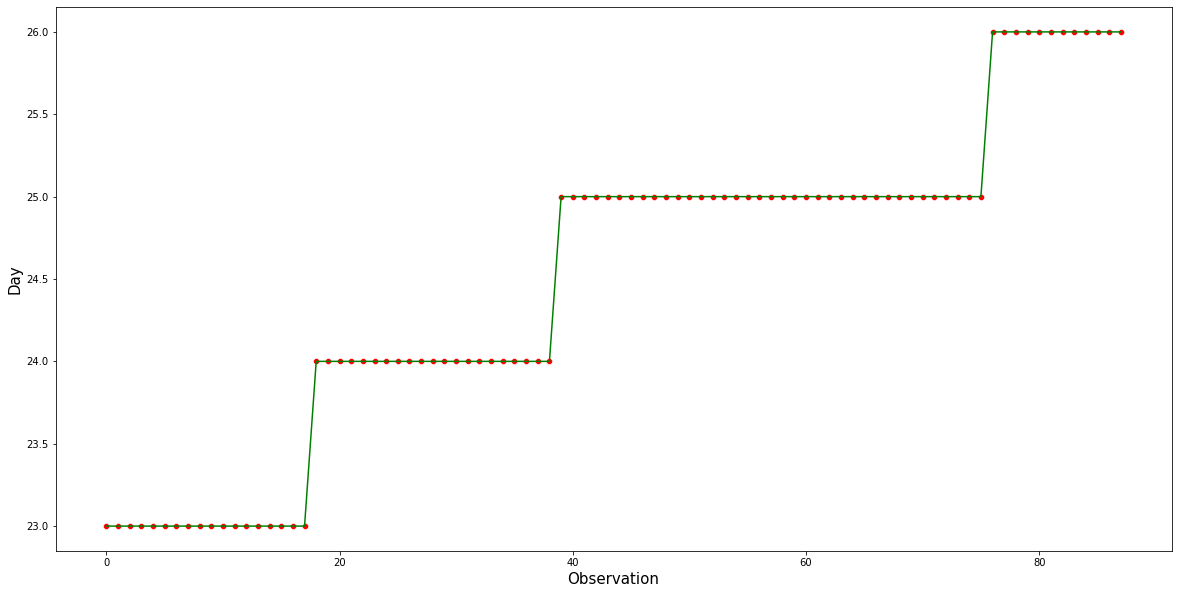

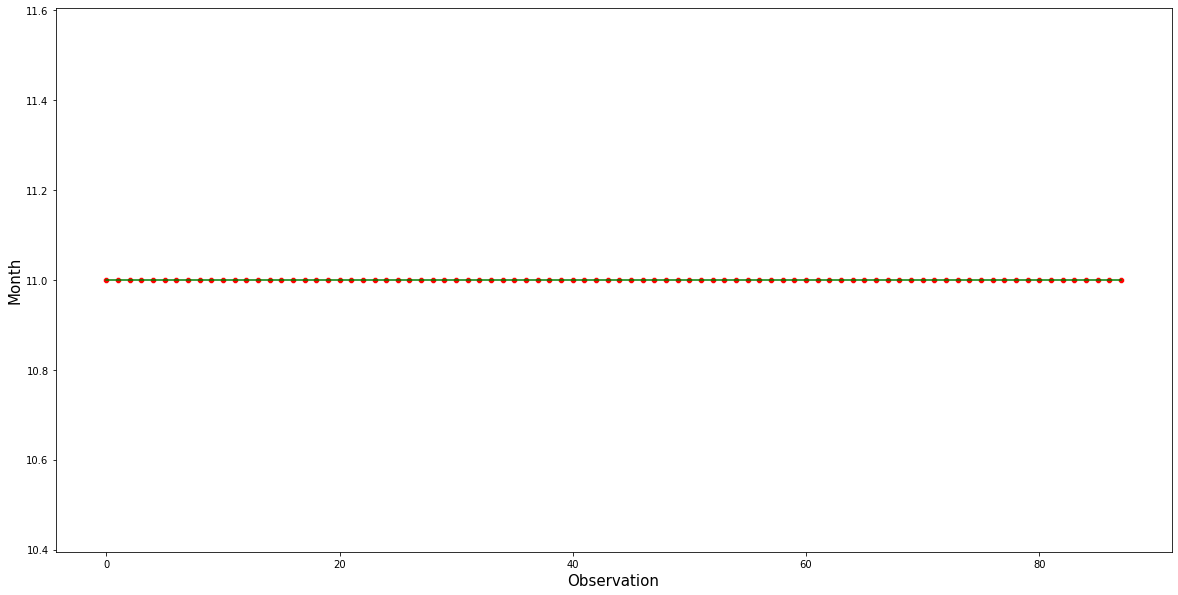

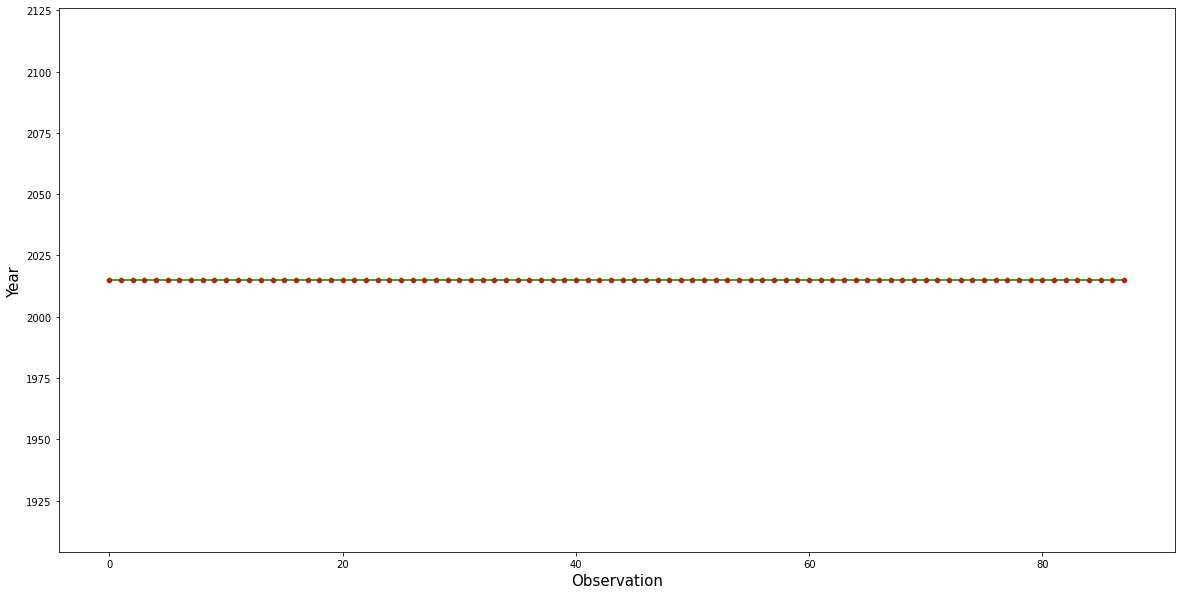

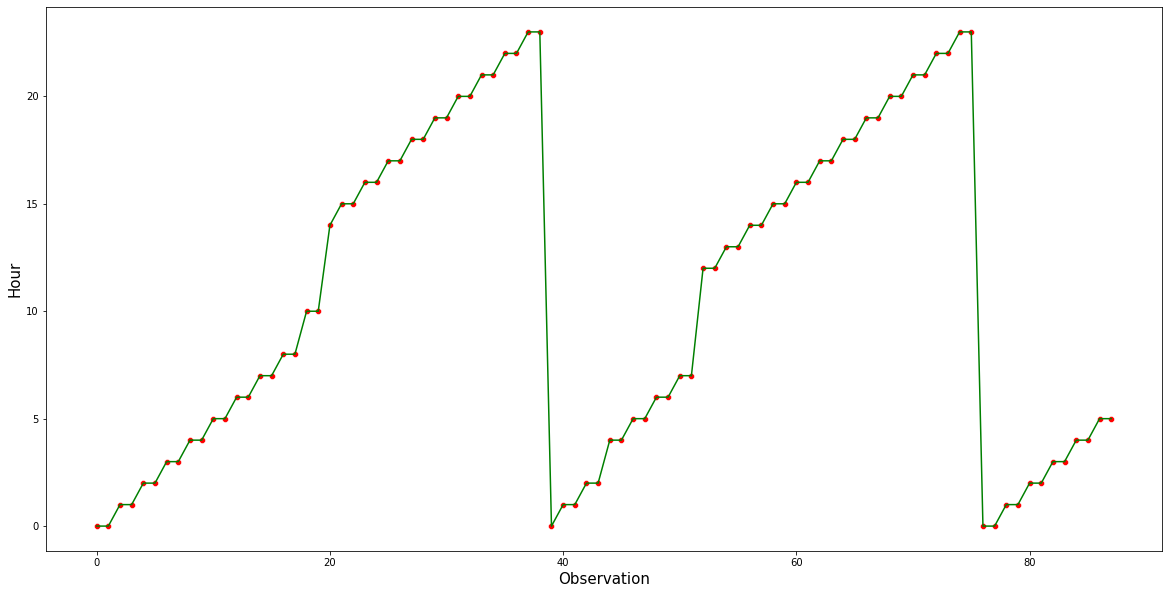

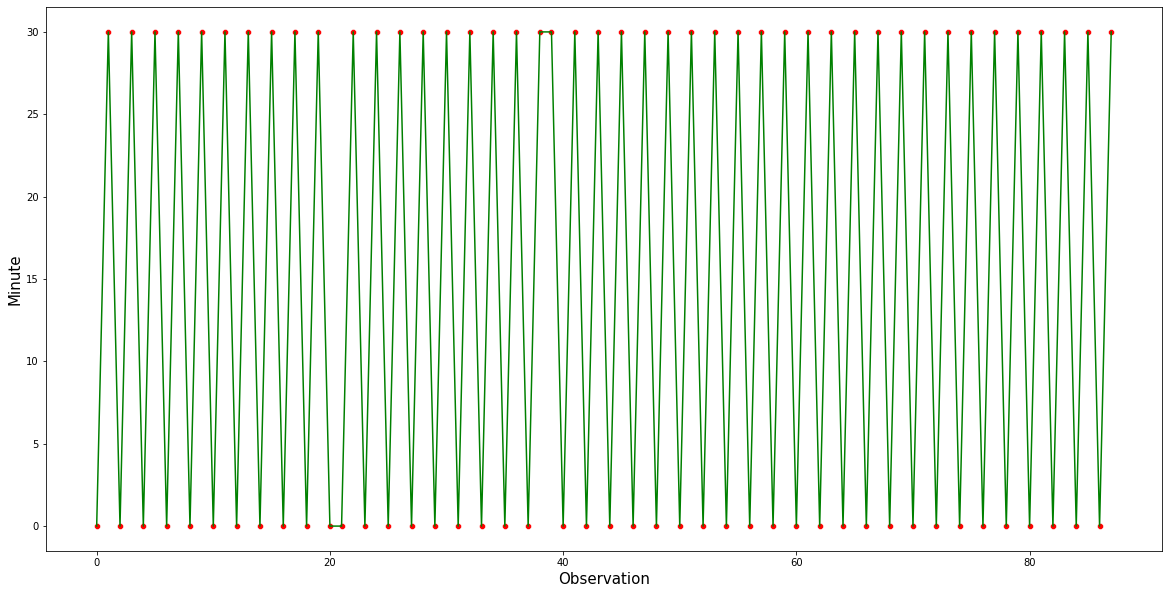

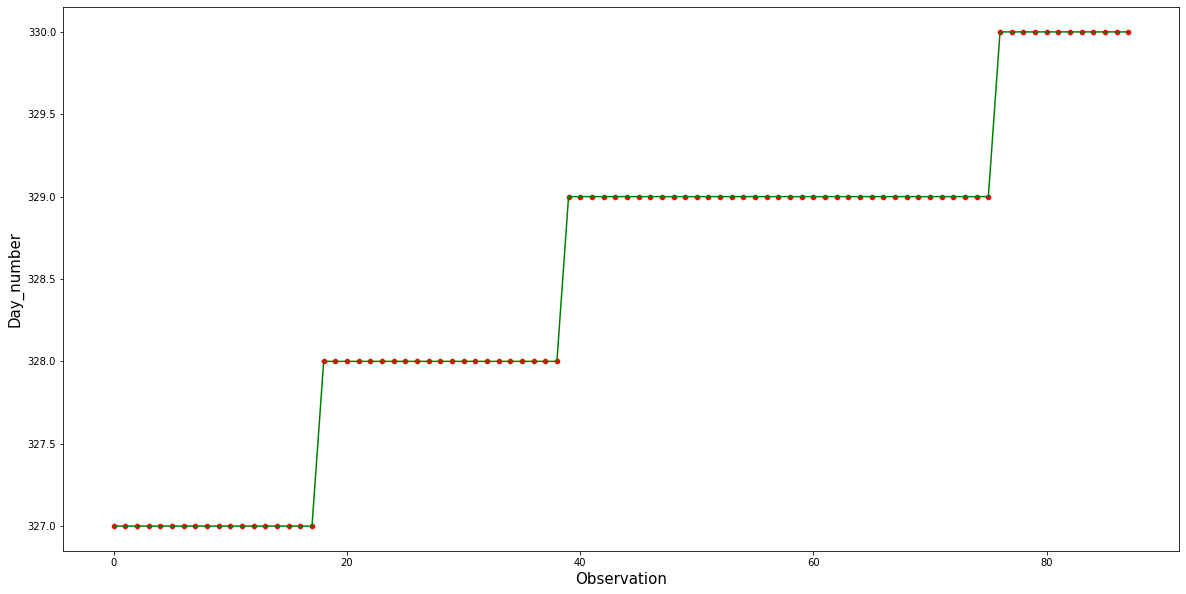

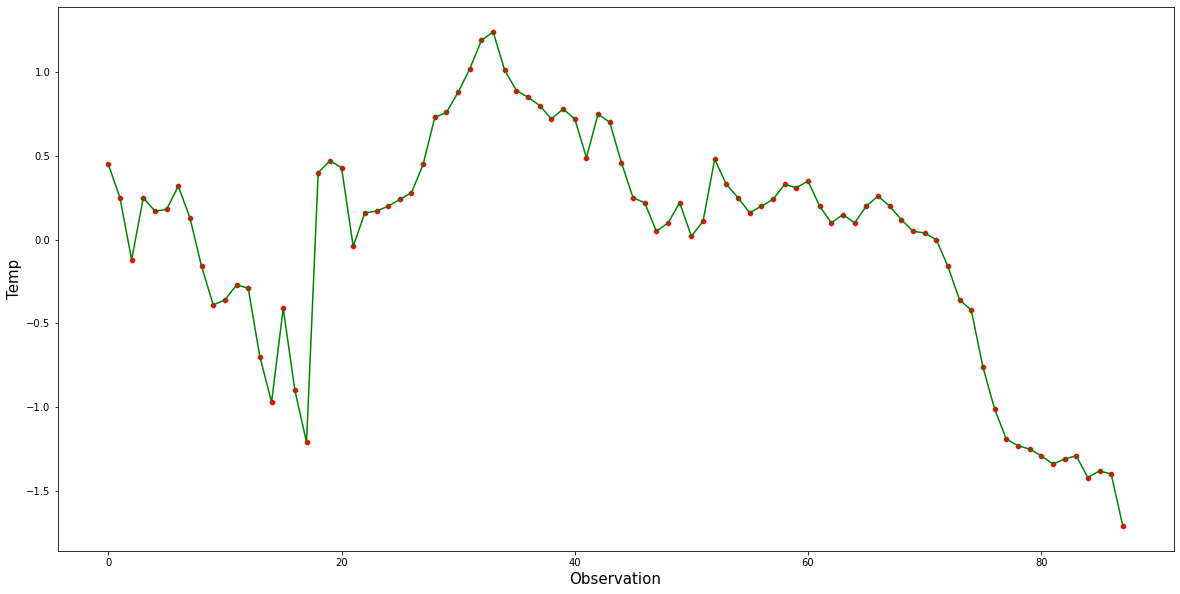

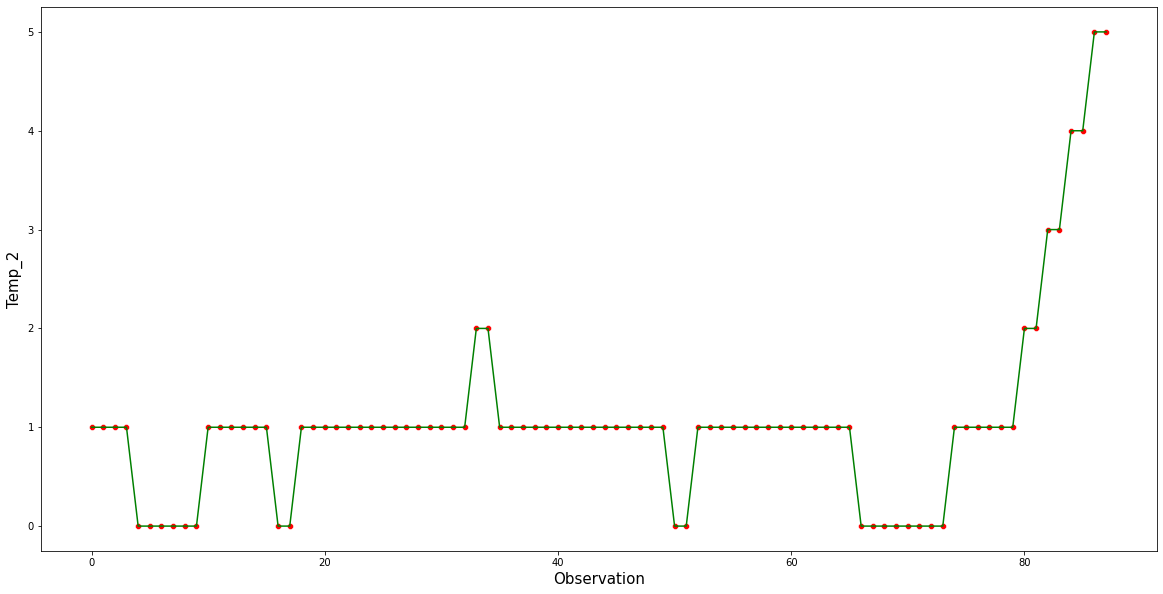

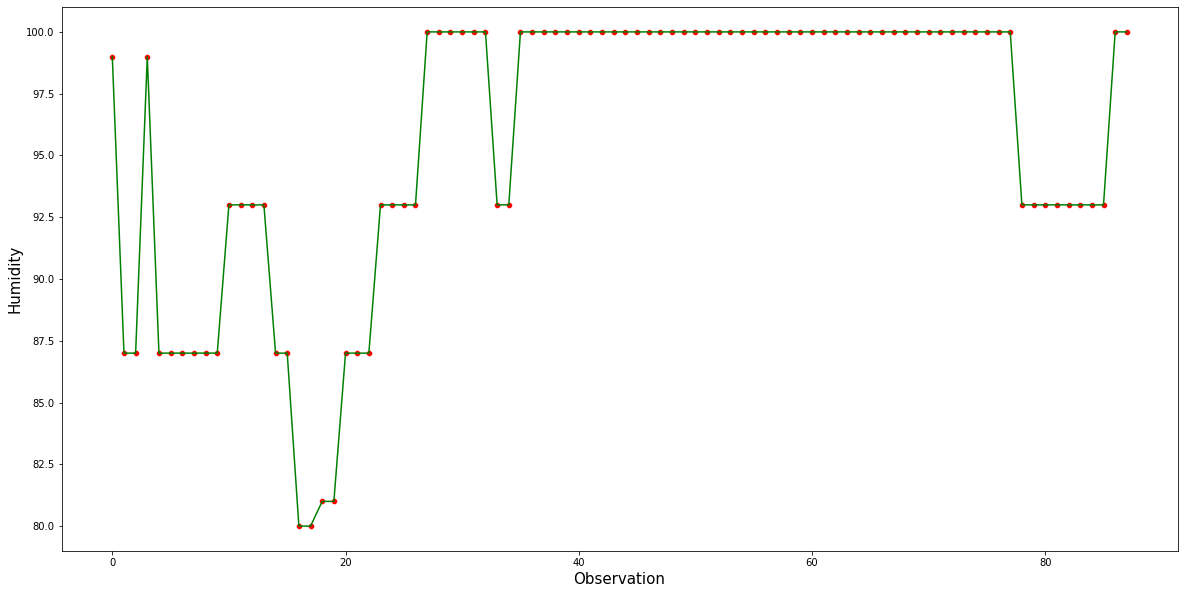

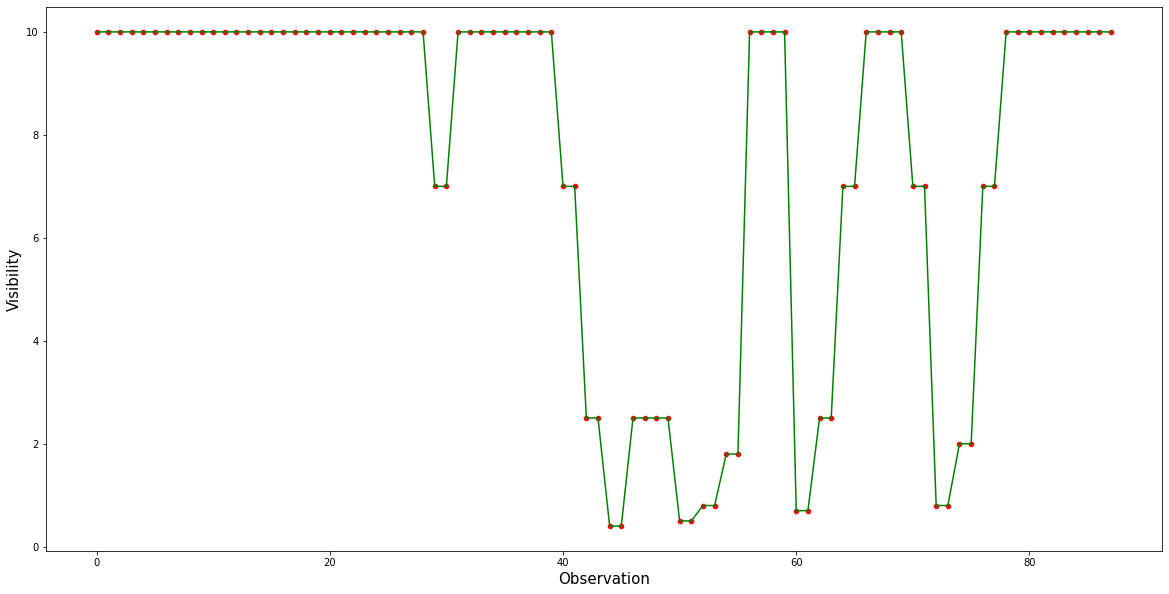

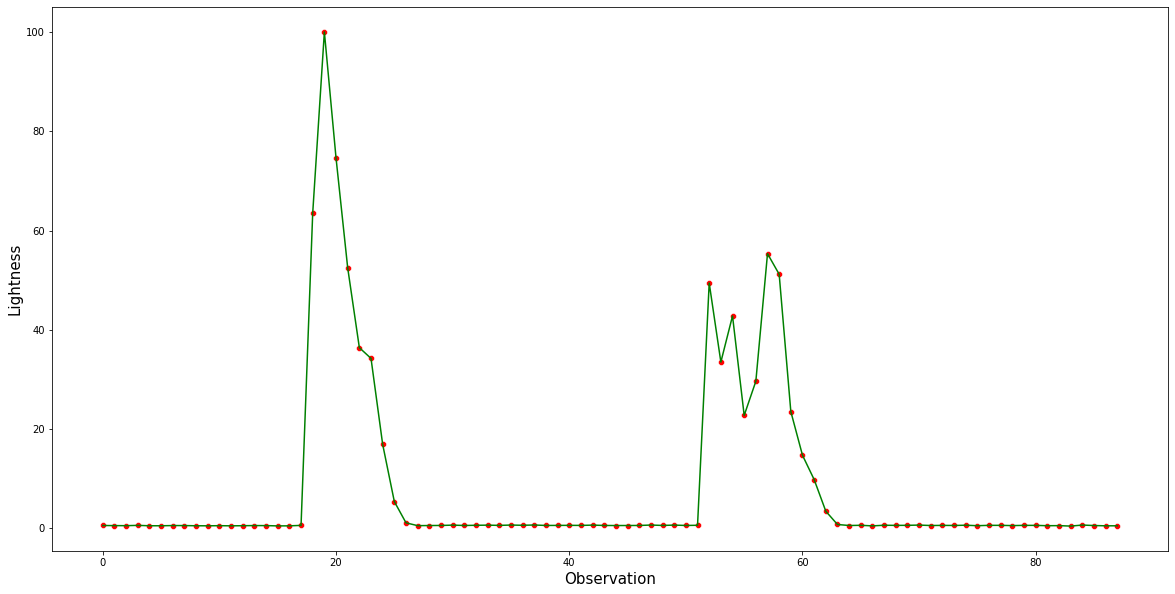

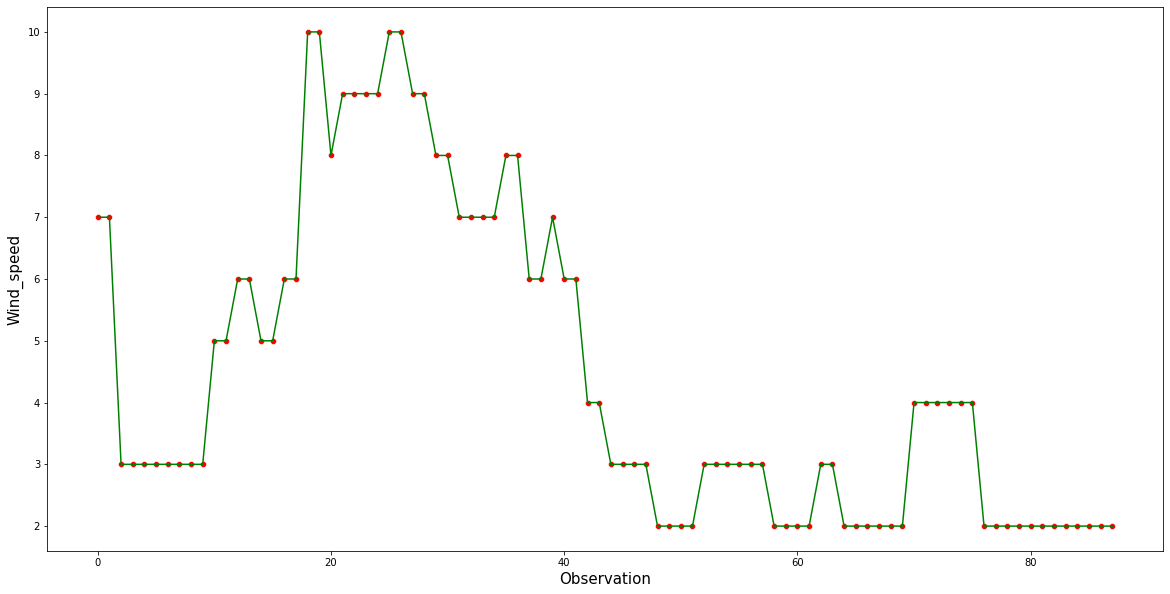

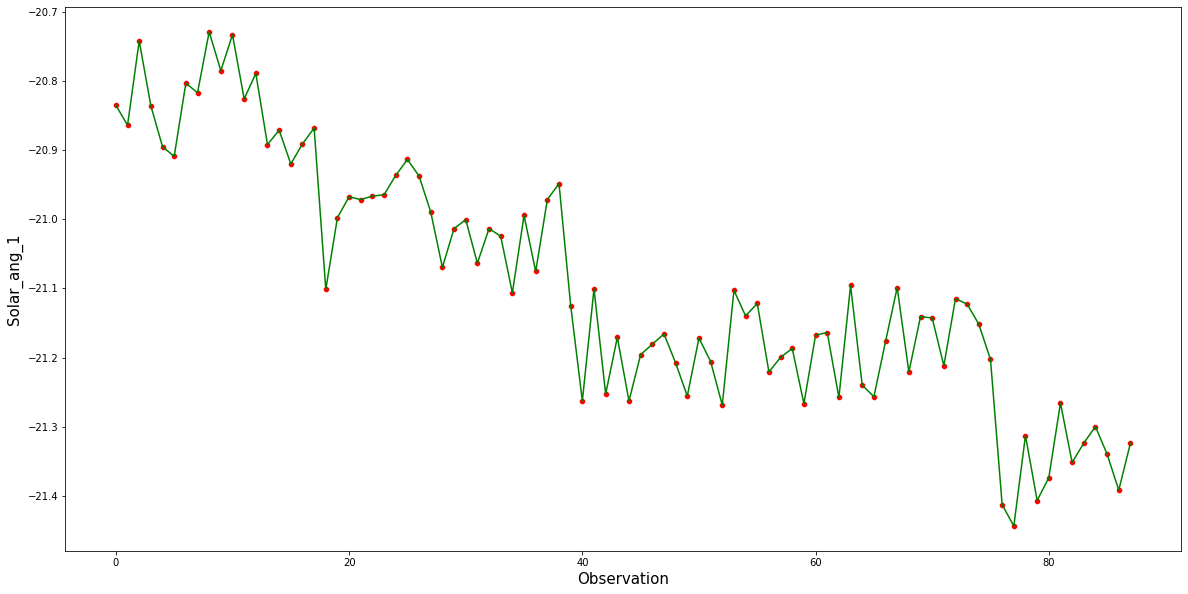

time: 2.68 s (started: 2022-10-16 04:37:19 +00:00)


In [ ]:
for column in data:
  plt.figure(figsize = (20,10));
  sn.scatterplot(y = data[column], x = data.index, color = 'red');
  sn.lineplot(y = data[column], x = data.index, color = 'green');
  plt.xlabel('Observation', fontsize = 15);
  plt.ylabel(column, fontsize = 15);

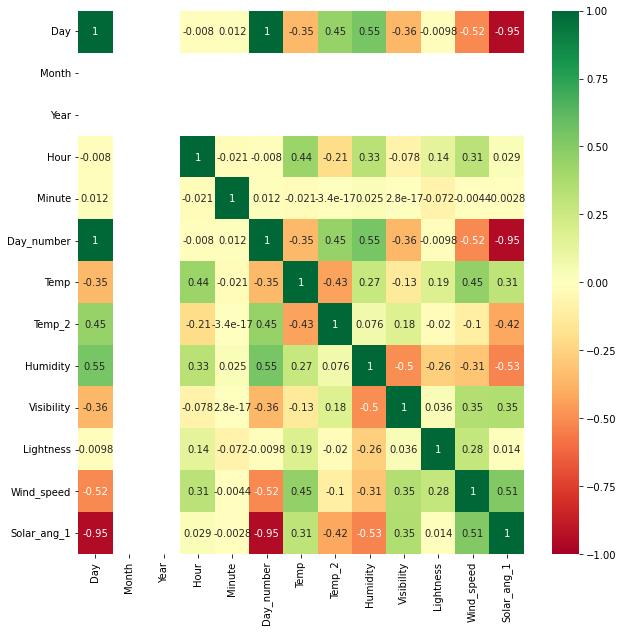

time: 659 ms (started: 2022-10-16 04:37:21 +00:00)


In [ ]:
plt.figure(figsize = (10, 10));
sn.heatmap(data.corr(), cmap = 'RdYlGn', vmax = 1, vmin = -1, annot = True);

In [ ]:
print(data.columns);

Index(['Day', 'Month', 'Year', 'Hour', 'Minute', 'Day_number', 'Temp',
       'Temp_2', 'Humidity', 'Visibility', 'Lightness', 'Wind_speed',
       'Solar_ang_1'],
      dtype='object')
time: 698 µs (started: 2022-10-16 04:37:22 +00:00)


In [ ]:
TARGET_TRAIN = 'Solar_ang_1';
TEST_SIZE = 0.10;
#TARGET_DELETE = ['Day', 'Month', 'Year', 'Hour', 'Minute', 'Day_number'];

time: 413 µs (started: 2022-10-16 04:37:22 +00:00)


In [ ]:
X = data.drop([TARGET_TRAIN], axis = 1);
y = data[TARGET_TRAIN];

X_train, X_test, y_train, y_test  =  train_test_split(X,y, test_size  =  TEST_SIZE);
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

y_test.to_excel('/content/y_test.xlsx');
X_test.to_excel('/content/X_test.xlsx');
#X_train = X_train.drop(TARGET_DELETE, axis = 1);
#X_test = X_test.drop(TARGET_DELETE, axis = 1);

(79, 12) (9, 12) (79,) (9,)
time: 26 ms (started: 2022-10-16 04:37:22 +00:00)


In [ ]:
N_SPLITS_DEFAULT = 10;
DEGREE_DEFAULT =  2;
N_NEIGHBORS_DEFAULT = 4;

time: 541 µs (started: 2022-10-16 04:37:22 +00:00)


# 2.1. Модель линейной регрессии

In [ ]:
N_SPLITS_LINE = 0;

if N_SPLITS_LINE <= 0: N_SPLITS_LINE = N_SPLITS_DEFAULT;

lin_reg = LinearRegression();
lin_reg.fit(X_train, y_train);
scoring   =  {'R2': 'r2',
           '-MSE': 'neg_mean_squared_error',
           '-MAE': 'neg_mean_absolute_error',
           'Max': 'max_error'};
scores = cross_validate(lin_reg, X_train, y_train, scoring = scoring, cv = ShuffleSplit(n_splits = N_SPLITS_LINE));
y_pred = lin_reg.predict(X_test);

# print('Cross-Validation errors');
# DF_reg  =  pd.DataFrame(scores);
# display(DF_reg);

print('Test errors');
print('Mean squared error on test_set: %.4f' % mse(y_test,y_pred));
print('R2  on test_set: %.4f' %  r2_score(y_test,y_pred));

Test errors
Mean squared error on test_set: 0.0024
R2  on test_set: 0.9169
time: 44.8 ms (started: 2022-10-16 04:37:22 +00:00)


# 2.2. Модель полиномиальной регрессии

In [ ]:
N_SPLITS_PINE = 0;
DEGREE_PINE = 0;

if N_SPLITS_PINE <= 0: N_SPLITS_PINE = N_SPLITS_DEFAULT;
if DEGREE_PINE <= 1: DEGREE_PINE = DEGREE_DEFAULT;

PF  =  poly(degree = DEGREE_PINE, include_bias = True, interaction_only = False);
#Rid = Ridge(alpha = 0.1);
LR = LinearRegression();
pipe = Pipeline([('polynomial_features', PF), ('lr', LR)])
pipe.fit(X_train, y_train);
scoring_pipe   =  {'R2': 'r2',
           '-MSE': 'neg_mean_squared_error',
           '-MAE': 'neg_mean_absolute_error',
           'Max': 'max_error'};
scores_pipe = cross_validate(pipe, X_train, y_train, scoring = scoring_pipe, cv = ShuffleSplit(n_splits = N_SPLITS_PINE));
y_pred_pipe = pipe.predict(X_test);

#print('Cross-Validation error');
#DF_reg_pipe  =  pd.DataFrame(scores_pipe);
#display(DF_reg_pipe);

print('Test errors');
print('Mean squared error on test_set: %.4f' % mse(y_test,y_pred_pipe));
print('R2  on test_set: %.4f' %  r2_score(y_test,y_pred_pipe));

Test errors
Mean squared error on test_set: 0.0132
R2  on test_set: 0.5371
time: 90.3 ms (started: 2022-10-16 04:37:22 +00:00)


# 2.3. Модель ближайших соседей (KNN)

In [ ]:
N_NEIGHBORS_KNN = 0;
N_SPLITS_KNN = 0;

if N_SPLITS_KNN <=  0: N_SPLITS_KNN = N_SPLITS_DEFAULT;
if N_NEIGHBORS_KNN <=  0: N_NEIGHBORS_KNN = N_NEIGHBORS_DEFAULT;

k_reg  =  KNeighborsRegressor(n_neighbors = N_NEIGHBORS_KNN, weights = 'distance');
k_reg.fit(X_train, y_train);
scoring_k   =  {'R2': 'r2',
           '-MSE': 'neg_mean_squared_error',
           '-MAE': 'neg_mean_absolute_error',
           'Max': 'max_error'};
scores_k = cross_validate(k_reg, X_train, y_train, scoring = scoring_k, cv = ShuffleSplit(n_splits = N_SPLITS_KNN));
y_pred_k = k_reg.predict(X_test);

#print('Cross-Validation error');
#DF_reg_k = pd.DataFrame(scores_k);
#display(DF_reg_k);

print('Test errors');
print('Mean squared error on test_set: %.4f' % mse(y_test,y_pred_k));
print('R2  on test_set: %.4f' %  r2_score(y_test,y_pred_k));

Test errors
Mean squared error on test_set: 0.0305
R2  on test_set: -0.0700
time: 65.9 ms (started: 2022-10-16 04:37:22 +00:00)


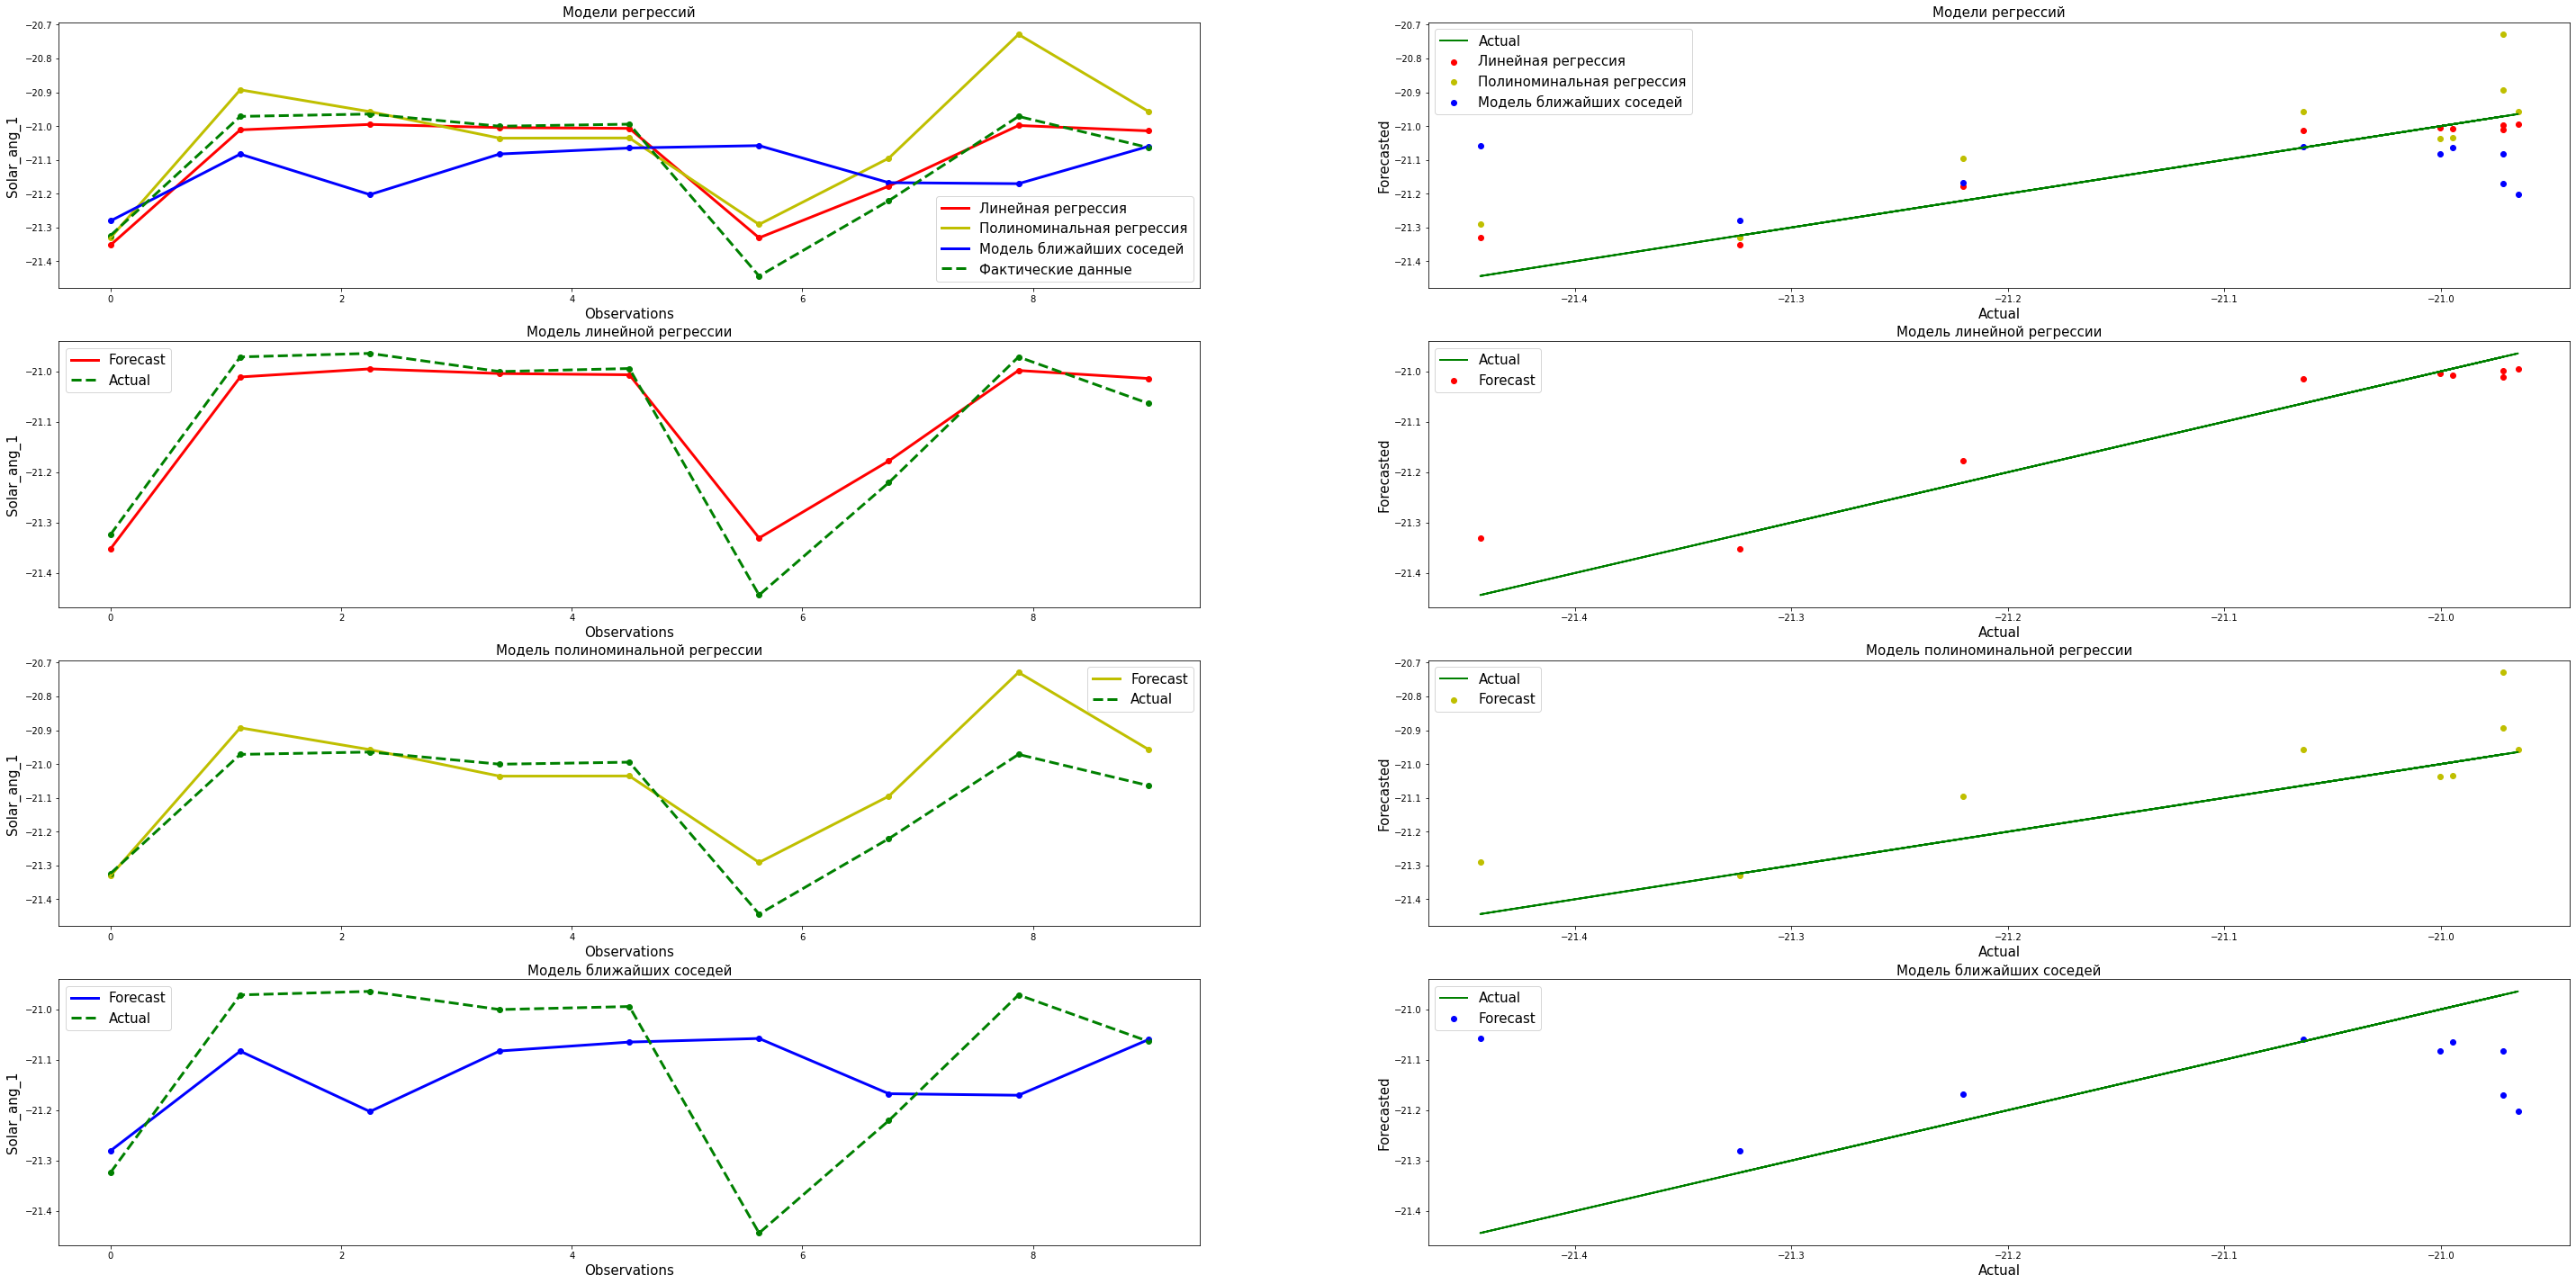

time: 2.2 s (started: 2022-10-16 04:37:22 +00:00)


In [ ]:
x = np.linspace(0, X_test.shape[0], X_test.shape[0]);
plt.figure(figsize = (50,25));
plt.subplot(421);
plt.title('Модели регрессий', fontsize = 15);
plt.scatter(x, y_pred, c = 'r');
plt.scatter(x, y_pred_pipe, c = 'y');
plt.scatter(x, y_pred_k, c = 'b');
plt.scatter(x, y_test, c = 'g');
plt.plot(x, y_pred, '-r', linewidth = 3, label = 'Линейная регрессия');
plt.plot(x, y_pred_pipe, '-y', linewidth = 3, label = 'Полиноминальная регрессия');
plt.plot(x, y_pred_k, '-b', linewidth = 3, label = 'Модель ближайших соседей');
plt.plot(x, y_test, 'g--', linewidth = 3, label = 'Фактические данные');
plt.legend(fontsize = 15);
plt.xlabel('Observations', fontsize = 15);
plt.ylabel(TARGET_TRAIN, fontsize = 15);
plt.subplot(422);
plt.title('Модели регрессий', fontsize = 15);
plt.plot(y_test, y_test, '-g', linewidth = 2, label = 'Actual');
plt.scatter(y_test, y_pred, label = 'Линейная регрессия', c = 'r');
plt.scatter(y_test, y_pred_pipe, label = 'Полиноминальная регрессия', c = 'y');
plt.scatter(y_test, y_pred_k, label =  'Модель ближайших соседей', c = 'b');
plt.legend(fontsize = 15);
plt.xlabel('Actual', fontsize = 15);
plt.ylabel('Forecasted', fontsize = 15);

plt.subplot(423);
plt.title('Модель линейной регрессии', fontsize = 15);
plt.scatter(x, y_pred, c = 'r');
plt.scatter(x, y_test, c = 'g');
plt.plot(x, y_pred, '-r', linewidth = 3, label = 'Forecast');
plt.plot(x, y_test, 'g--', linewidth = 3, label = 'Actual');
plt.legend(fontsize = 15);
plt.xlabel('Observations', fontsize = 15);
plt.ylabel(TARGET_TRAIN, fontsize = 15);
plt.subplot(424);
plt.title('Модель линейной регрессии', fontsize = 15);
plt.plot(y_test, y_test, '-g', linewidth = 2, label = 'Actual');
plt.scatter(y_test, y_pred, label = 'Forecast', c = 'r');
plt.legend(fontsize = 15);
plt.xlabel('Actual', fontsize = 15);
plt.ylabel('Forecasted', fontsize = 15);

plt.subplot(425);
plt.title('Модель полиноминальной регрессии', fontsize = 15);
plt.scatter(x, y_pred_pipe, c = 'y');
plt.scatter(x, y_test, c = 'g');
plt.plot(x, y_pred_pipe, '-y', linewidth = 3, label = 'Forecast');
plt.plot(x, y_test, 'g--', linewidth = 3, label = 'Actual');
plt.legend(fontsize = 15);
plt.xlabel('Observations', fontsize = 15);
plt.ylabel(TARGET_TRAIN, fontsize = 15);
plt.subplot(426);
plt.title('Модель полиноминальной регрессии', fontsize = 15);
plt.plot(y_test, y_test, '-g', linewidth = 2, label = 'Actual');
plt.scatter(y_test, y_pred_pipe, label = 'Forecast', c = 'y');
plt.legend(fontsize = 15);
plt.xlabel('Actual', fontsize = 15);
plt.ylabel('Forecasted', fontsize = 15);

plt.subplot(427);
plt.title('Модель ближайших соседей', fontsize = 15);
plt.scatter(x, y_pred_k, c = 'b');
plt.scatter(x, y_test, c = 'g');
plt.plot(x, y_pred_k, '-b', linewidth = 3, label = 'Forecast');
plt.plot(x, y_test, 'g--', linewidth = 3, label = 'Actual');
plt.legend(fontsize = 15);
plt.xlabel('Observations', fontsize = 15);
plt.ylabel(TARGET_TRAIN, fontsize = 15);
plt.subplot(428);
plt.title('Модель ближайших соседей', fontsize = 15);
plt.plot(y_test, y_test, '-g', linewidth = 2, label = 'Actual');
plt.scatter(y_test, y_pred_k, label = 'Forecast', c = 'b');
plt.legend(fontsize = 15);
plt.xlabel('Actual', fontsize = 15);
plt.ylabel('Forecasted', fontsize = 15);
plt.savefig('basic_reg_algorithms.png');
plt.show();

plt.figure(figsize = (10, 10));
sn.heatmap(data.corr(), cmap = 'RdYlGn', vmax = 1, vmin = -1, annot = True);

# Часть 3. Ансамблевые алгоритмы и визуализация

---

Задание, которое в форме для ДЗ - к очищенным данным применить ансамблевые модели регресии, которые были рассмотрены на занятии (случайный лес, градиентный бустинг, стэкинг). Предварительно данные разделить на массивы признаков и целевой переменной, выделить обучающую и тестовую выборки. Изменяя входные параметры ансамблевых моделей, добиться удовлетворительной (по мнению студента) точности прогноза.

---
Поработать с рассмотренными библиотеками
Выбрать ту, которая нравится больше (на вкус, цвет и сложность). Использовать ее в дальнейшем



*   Построить один график отображающий Ваши исходные данные
*   Построить один-два графика для отображения результатов прогноза





P.S.: При построении графиков задать различные маркеры (круги, ромбы, квадраты, треугольники...) для точек данных, цвет линий и точек, толщину линий. Обязательно добавить подписи к осями графика и название графика сверху

---

In [ ]:
!pip install ipython-autotime
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 2.33 s (started: 2022-10-16 04:37:25 +00:00)


In [ ]:
test_data = pd.read_excel('/content/s10_cleared_without_index.xlsx');
data = pd.DataFrame(data = test_data);

time: 25.5 ms (started: 2022-10-16 04:37:27 +00:00)


In [ ]:
TARGET_TRAIN = 'Solar_ang_1';
TEST_SIZE = 0.10;
#TARGET_DELETE = ['Day', 'Month', 'Year', 'Hour', 'Minute', 'Day_number'];

time: 423 µs (started: 2022-10-16 04:37:27 +00:00)


In [ ]:
X = data.drop([TARGET_TRAIN], axis = 1);
y = data[TARGET_TRAIN];

X_train, X_test, y_train, y_test  =  train_test_split(X,y, test_size  =  TEST_SIZE);
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape);

y_test.to_excel('/content/y_test.xlsx');
X_test.to_excel('/content/X_test.xlsx');

#X_train = X_train.drop(TARGET_DELETE, axis = 1);
#X_test = X_test.drop(TARGET_DELETE, axis = 1);

(79, 12) (9, 12) (79,) (9,)
time: 27.6 ms (started: 2022-10-16 04:37:27 +00:00)


# 3.1. Обычные деревья решений

---

In [ ]:
N_SPLITS_DT = 0;

if N_SPLITS_DT <=  0: N_SPLITS_DT = N_SPLITS_DEFAULT;

DT = DecisionTreeRegressor(max_depth=1000)
DT.fit(X_train, y_train)
scoring_DT  = {'R2': 'r2',
           '-MSE': 'neg_mean_squared_error',
           '-MAE': 'neg_mean_absolute_error',
           'Max': 'max_error'}
scores_DT = cross_validate(DT, X_train, y_train, scoring = scoring_DT, cv = ShuffleSplit(n_splits = N_SPLITS_DT));
y_pred_DT = DT.predict(X_test)

#print('Cross-Validation error')
#DF_reg_DT = pd.DataFrame(scores_DT)
#display(DF_reg_DT)

print('Mean squared error on test_set: %.4f' % mse(y_test,y_pred_DT))
print('R2  on test_set: %.4f' %  r2_score(y_test,y_pred_DT))

Mean squared error on test_set: 0.0064
R2  on test_set: 0.7189
time: 42.6 ms (started: 2022-10-16 04:37:27 +00:00)


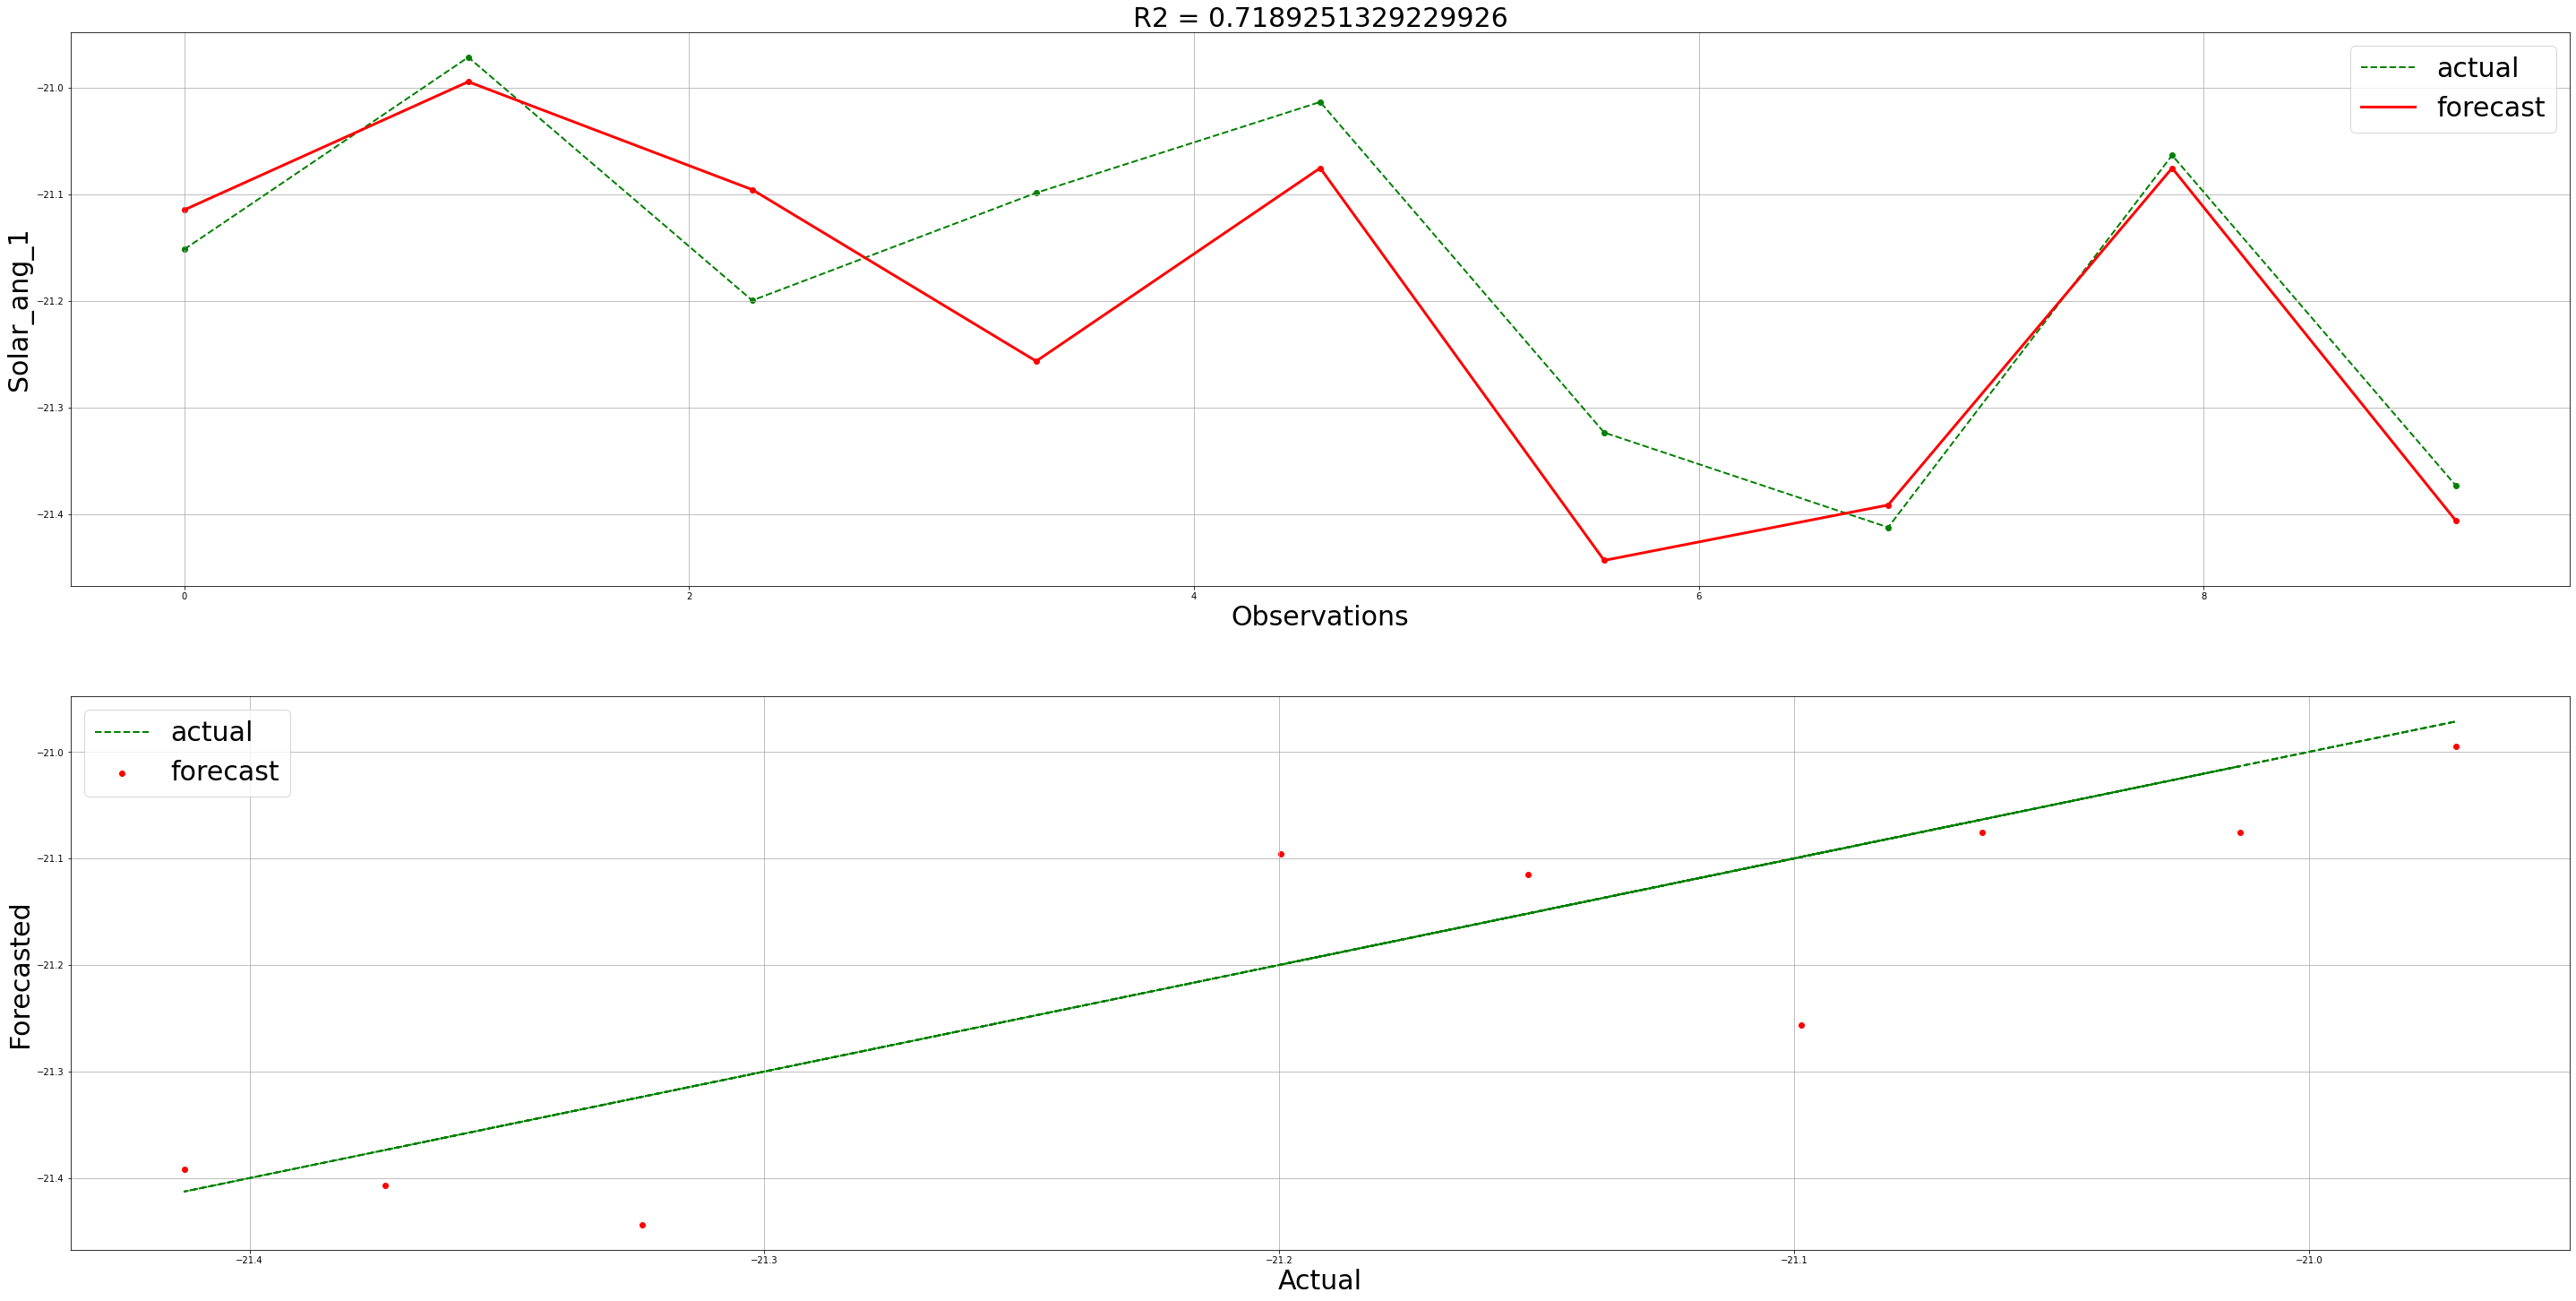

time: 737 ms (started: 2022-10-16 04:37:27 +00:00)


In [ ]:
x = np.linspace(0, X_test.shape[0], X_test.shape[0]);
plt.figure(figsize=(50,25));
plt.subplot(211);
plt.title(f'R2 = {r2_score(y_test,y_pred_DT)}', fontsize=30);
plt.scatter(x, y_pred_DT, c='r');
plt.scatter(x, y_test, c='g');
plt.plot(x, y_test, '--g', linewidth=2, label='actual');
plt.plot(x, y_pred_DT, '-r', linewidth=3, label='forecast');
plt.legend(fontsize=30);
plt.xlabel('Observations', fontsize=30);
plt.ylabel(TARGET_TRAIN, fontsize=30);
plt.grid();
plt.subplot(212);
plt.plot(y_test, y_test, '--g', linewidth=2, label='actual');
plt.scatter(y_test, y_pred_DT, label='forecast', c='r');
plt.legend(fontsize=30);
plt.xlabel('Actual', fontsize=30);
plt.ylabel('Forecasted', fontsize=30);
plt.grid();

In [ ]:
text_representation = tree.export_text(DT, feature_names=list(X));
with open("decistion_tree.txt", "w") as fout:
    fout.write(text_representation);

time: 3.35 ms (started: 2022-10-16 04:37:28 +00:00)


In [ ]:
dot_data = tree.export_graphviz(DT,
                                feature_names=list(X),
                                class_names=y,
                                filled=True);

graph = graphviz.Source(dot_data, format="png");
graph;
graph.render('decistion_tree',cleanup=True);

time: 801 ms (started: 2022-10-16 04:37:28 +00:00)


# 3.2. Ансамблевые модели

---

Бэггинг. Случайный лес

In [ ]:
N_SPLITS_RF = 0;

if N_SPLITS_RF <=  0: N_SPLITS_RF = N_SPLITS_DEFAULT;

params_RF = {'n_estimators':100,
          'max_depth':6,
          'criterion':'absolute_error',
          'max_features':5
          }
RF = RandomForestRegressor(**params_RF);
RF.fit(X_train, y_train);
scoring_RF  = {'R2': 'r2',
           '-MSE': 'neg_mean_squared_error',
           '-MAE': 'neg_mean_absolute_error',
           'Max': 'max_error'};
scores_RF = cross_validate(RF, X_train, y_train, scoring = scoring_RF, cv = ShuffleSplit(n_splits = N_SPLITS_RF ));
y_pred_RF = RF.predict(X_test);

#print('Cross-Validation error');
#DF_reg_RF = pd.DataFrame(scores_RF);
#display(DF_reg_RF);

print('Mean squared error on test_set: %.4f' % mse(y_test,y_pred_RF));
print('R2  on test_set: %.4f' %  r2_score(y_test,y_pred_RF));

Mean squared error on test_set: 0.0020
R2  on test_set: 0.9115
time: 1.34 s (started: 2022-10-16 04:37:29 +00:00)


Бустинг. Градиентный бустинг

In [ ]:
N_SPLITS_GB = 0;

if N_SPLITS_GB <=  0: N_SPLITS_GB = N_SPLITS_DEFAULT;

params_GB = {'n_estimators':220,
          'max_depth':6,
          'learning_rate':0.008};

GB = GradientBoostingRegressor(**params_GB);
GB.fit(X_train, y_train);
scoring_GB  = {'R2': 'r2',
           '-MSE': 'neg_mean_squared_error',
           '-MAE': 'neg_mean_absolute_error',
           'Max': 'max_error'};
scores_GB = cross_validate(GB, X_train, y_train, scoring = scoring_GB, cv = ShuffleSplit(n_splits = N_SPLITS_GB));
y_pred_GB = GB.predict(X_test);

#print('Cross-Vlidation error');
#DF_reg_GB = pd.DataFrame(scores_GB);
#display(DF_reg_GB);

print('Mean squared error on test_set: %.4f' % mse(y_test,y_pred_GB));
print('R2  on test_set: %.4f' %  r2_score(y_test,y_pred_GB));

Mean squared error on test_set: 0.0031
R2  on test_set: 0.8620
time: 714 ms (started: 2022-10-16 04:37:30 +00:00)


Стэкинг

In [ ]:
N_SPLITS_STACK = 0;

if N_SPLITS_STACK <=  0: N_SPLITS_STACK = N_SPLITS_DEFAULT;

estimators = [('dt', DT)];
stack_reg = StackingRegressor(estimators = estimators, final_estimator = RandomForestRegressor(), n_jobs = -1, passthrough = True);
stack_reg.fit(X_train, y_train);

scoring_stack  = {'R2': 'r2',
           '-MSE': 'neg_mean_squared_error',
           '-MAE': 'neg_mean_absolute_error',
           'Max': 'max_error'};
scores_stack = cross_validate(stack_reg, X_train, y_train, scoring = scoring_stack, cv = ShuffleSplit(n_splits = N_SPLITS_STACK));
y_pred_stack = stack_reg.predict(X_test);

#print('Cross-Validation error');
#DF_reg_stack = pd.DataFrame(scores_stack);
#display(DF_reg_stack);

print('Mean squared error on test_set: %.4f' % mse(y_test,y_pred_stack));
print('R2  on test_set: %.4f' %  r2_score(y_test,y_pred_stack));
print('MAE  on test_set: %.4f' %  mae(y_test,y_pred_stack));
print('nMAE  on test_set: %.4f' %  (mae(y_test,y_pred_stack)/np.mean(y_test)));
print('ME  on test_set: %.4f' %  max_error(y_test,y_pred_stack));

Mean squared error on test_set: 0.0018
R2  on test_set: 0.9230
MAE  on test_set: 0.0367
nMAE  on test_set: -0.0017
ME  on test_set: 0.0799
time: 3.95 s (started: 2022-10-16 04:37:31 +00:00)


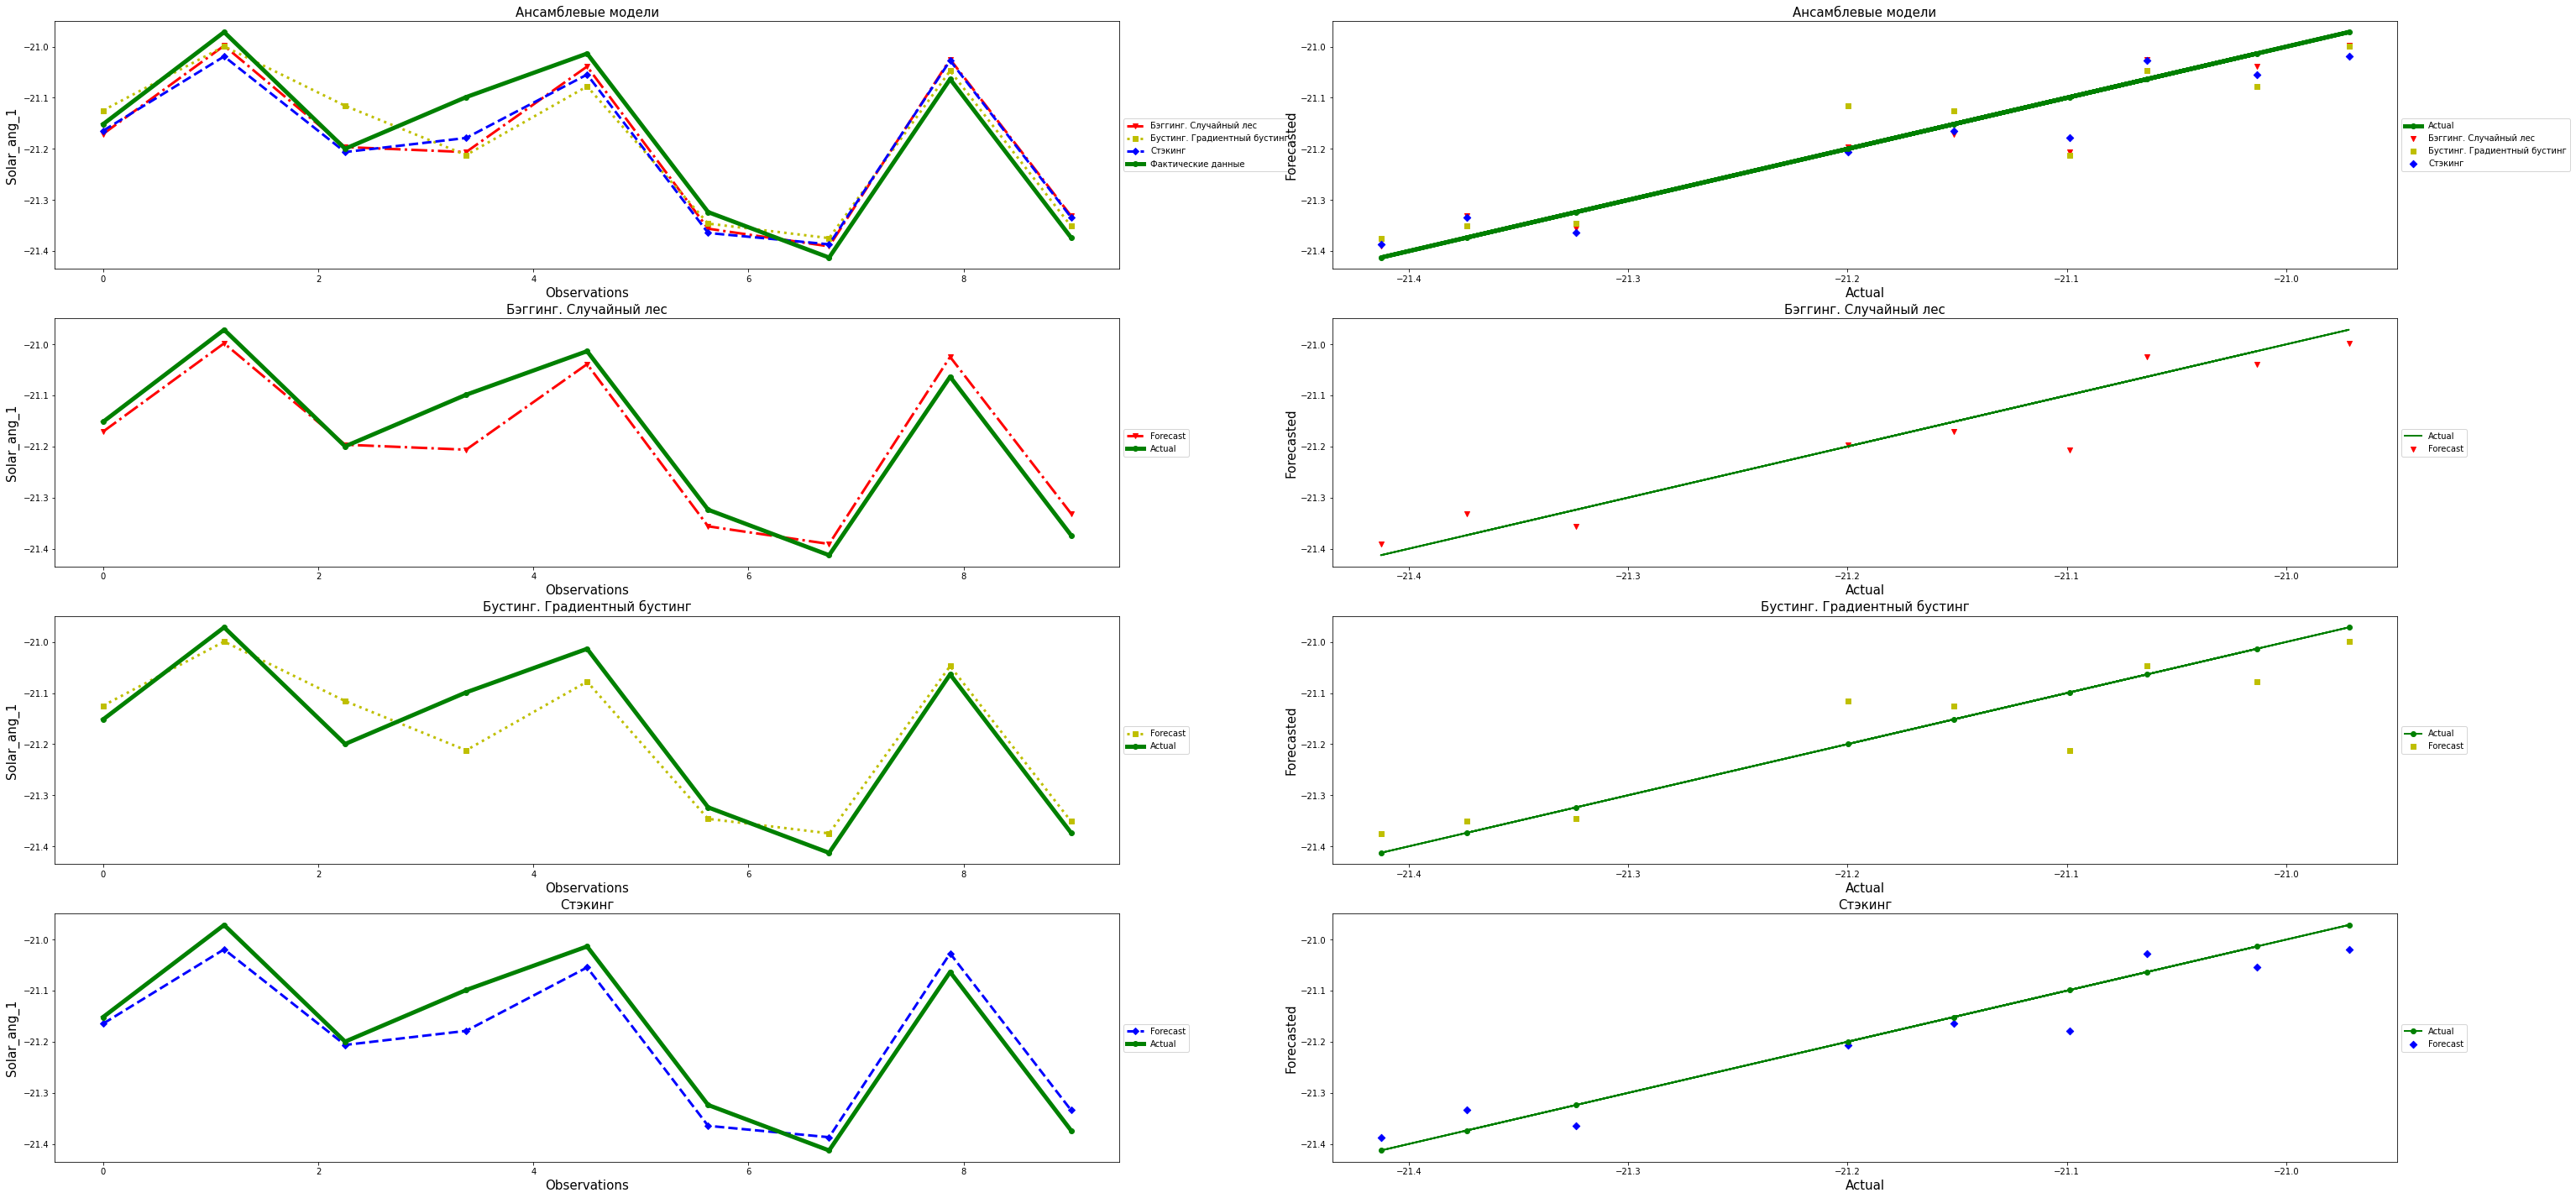

time: 4.23 s (started: 2022-10-16 04:37:35 +00:00)


In [ ]:
x = np.linspace(0, X_test.shape[0], X_test.shape[0]);
plt.figure(figsize = (50,25));
plt.subplot(421);
plt.title('Ансамблевые модели', fontsize = 15);
plt.plot(x, y_pred_RF, '-.rv', linewidth = 3, label = 'Бэггинг. Случайный лес');
plt.plot(x, y_pred_GB, ':ys', linewidth = 3, label = 'Бустинг. Градиентный бустинг');
plt.plot(x, y_pred_stack, '--bD', linewidth = 3, label = 'Стэкинг');
plt.plot(x, y_test, '-go', linewidth = 5, label = 'Фактические данные');
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Observations', fontsize = 15);
plt.ylabel(TARGET_TRAIN, fontsize = 15);
plt.subplot(422);
plt.title('Ансамблевые модели', fontsize = 15);
plt.plot(y_test, y_test, '-go', linewidth = 5, label = 'Actual');
plt.scatter(y_test, y_pred_RF, label = 'Бэггинг. Случайный лес', c = 'r', marker = 'v');
plt.scatter(y_test, y_pred_GB, label = 'Бустинг. Градиентный бустинг', c = 'y', marker = 's');
plt.scatter(y_test, y_pred_stack, label =  'Стэкинг', c = 'b', marker = 'D');
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Actual', fontsize = 15);
plt.ylabel('Forecasted', fontsize = 15);

plt.subplot(423);
plt.title('Бэггинг. Случайный лес', fontsize = 15);
plt.plot(x, y_pred_RF, '-.rv', linewidth = 3, label = 'Forecast');
plt.plot(x, y_test, '-go', linewidth = 5, label = 'Actual');
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Observations', fontsize = 15);
plt.ylabel(TARGET_TRAIN, fontsize = 15);
plt.subplot(424);
plt.title('Бэггинг. Случайный лес', fontsize = 15);
plt.plot(y_test, y_test, '-g', linewidth = 2, label = 'Actual');
plt.scatter(y_test, y_pred_RF, label = 'Forecast', c = 'r', marker = 'v');
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));
plt.xlabel('Actual', fontsize = 15);
plt.ylabel('Forecasted', fontsize = 15);

plt.subplot(425);
plt.title('Бустинг. Градиентный бустинг', fontsize = 15);
plt.plot(x, y_pred_GB, ':ys', linewidth = 3, label = 'Forecast');
plt.plot(x, y_test, '-go', linewidth = 5, label = 'Actual');
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Observations', fontsize = 15);
plt.ylabel(TARGET_TRAIN, fontsize = 15);
plt.subplot(426);
plt.title('Бустинг. Градиентный бустинг', fontsize = 15);
plt.plot(y_test, y_test, '-go', linewidth = 2, label = 'Actual');
plt.scatter(y_test, y_pred_GB, label = 'Forecast', c = 'y', marker = 's');
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Actual', fontsize = 15);
plt.ylabel('Forecasted', fontsize = 15);

plt.subplot(427);
plt.title('Стэкинг', fontsize = 15);
plt.plot(x, y_pred_stack, '--bD', linewidth = 3, label = 'Forecast');
plt.plot(x, y_test, '-go', linewidth = 5, label = 'Actual');
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Observations', fontsize = 15);
plt.ylabel(TARGET_TRAIN, fontsize = 15);
plt.subplot(428);
plt.title('Стэкинг', fontsize = 15);
plt.plot(y_test, y_test, '-go', linewidth = 2, label = 'Actual');
plt.scatter(y_test, y_pred_stack, label = 'Forecast', c = 'b', marker = 'D');
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Actual', fontsize = 15);
plt.ylabel('Forecasted', fontsize = 15);
plt.savefig('ensemble_algorithms.png');
plt.show();

---

# Вывод 2 и 3 частей для сравнения.

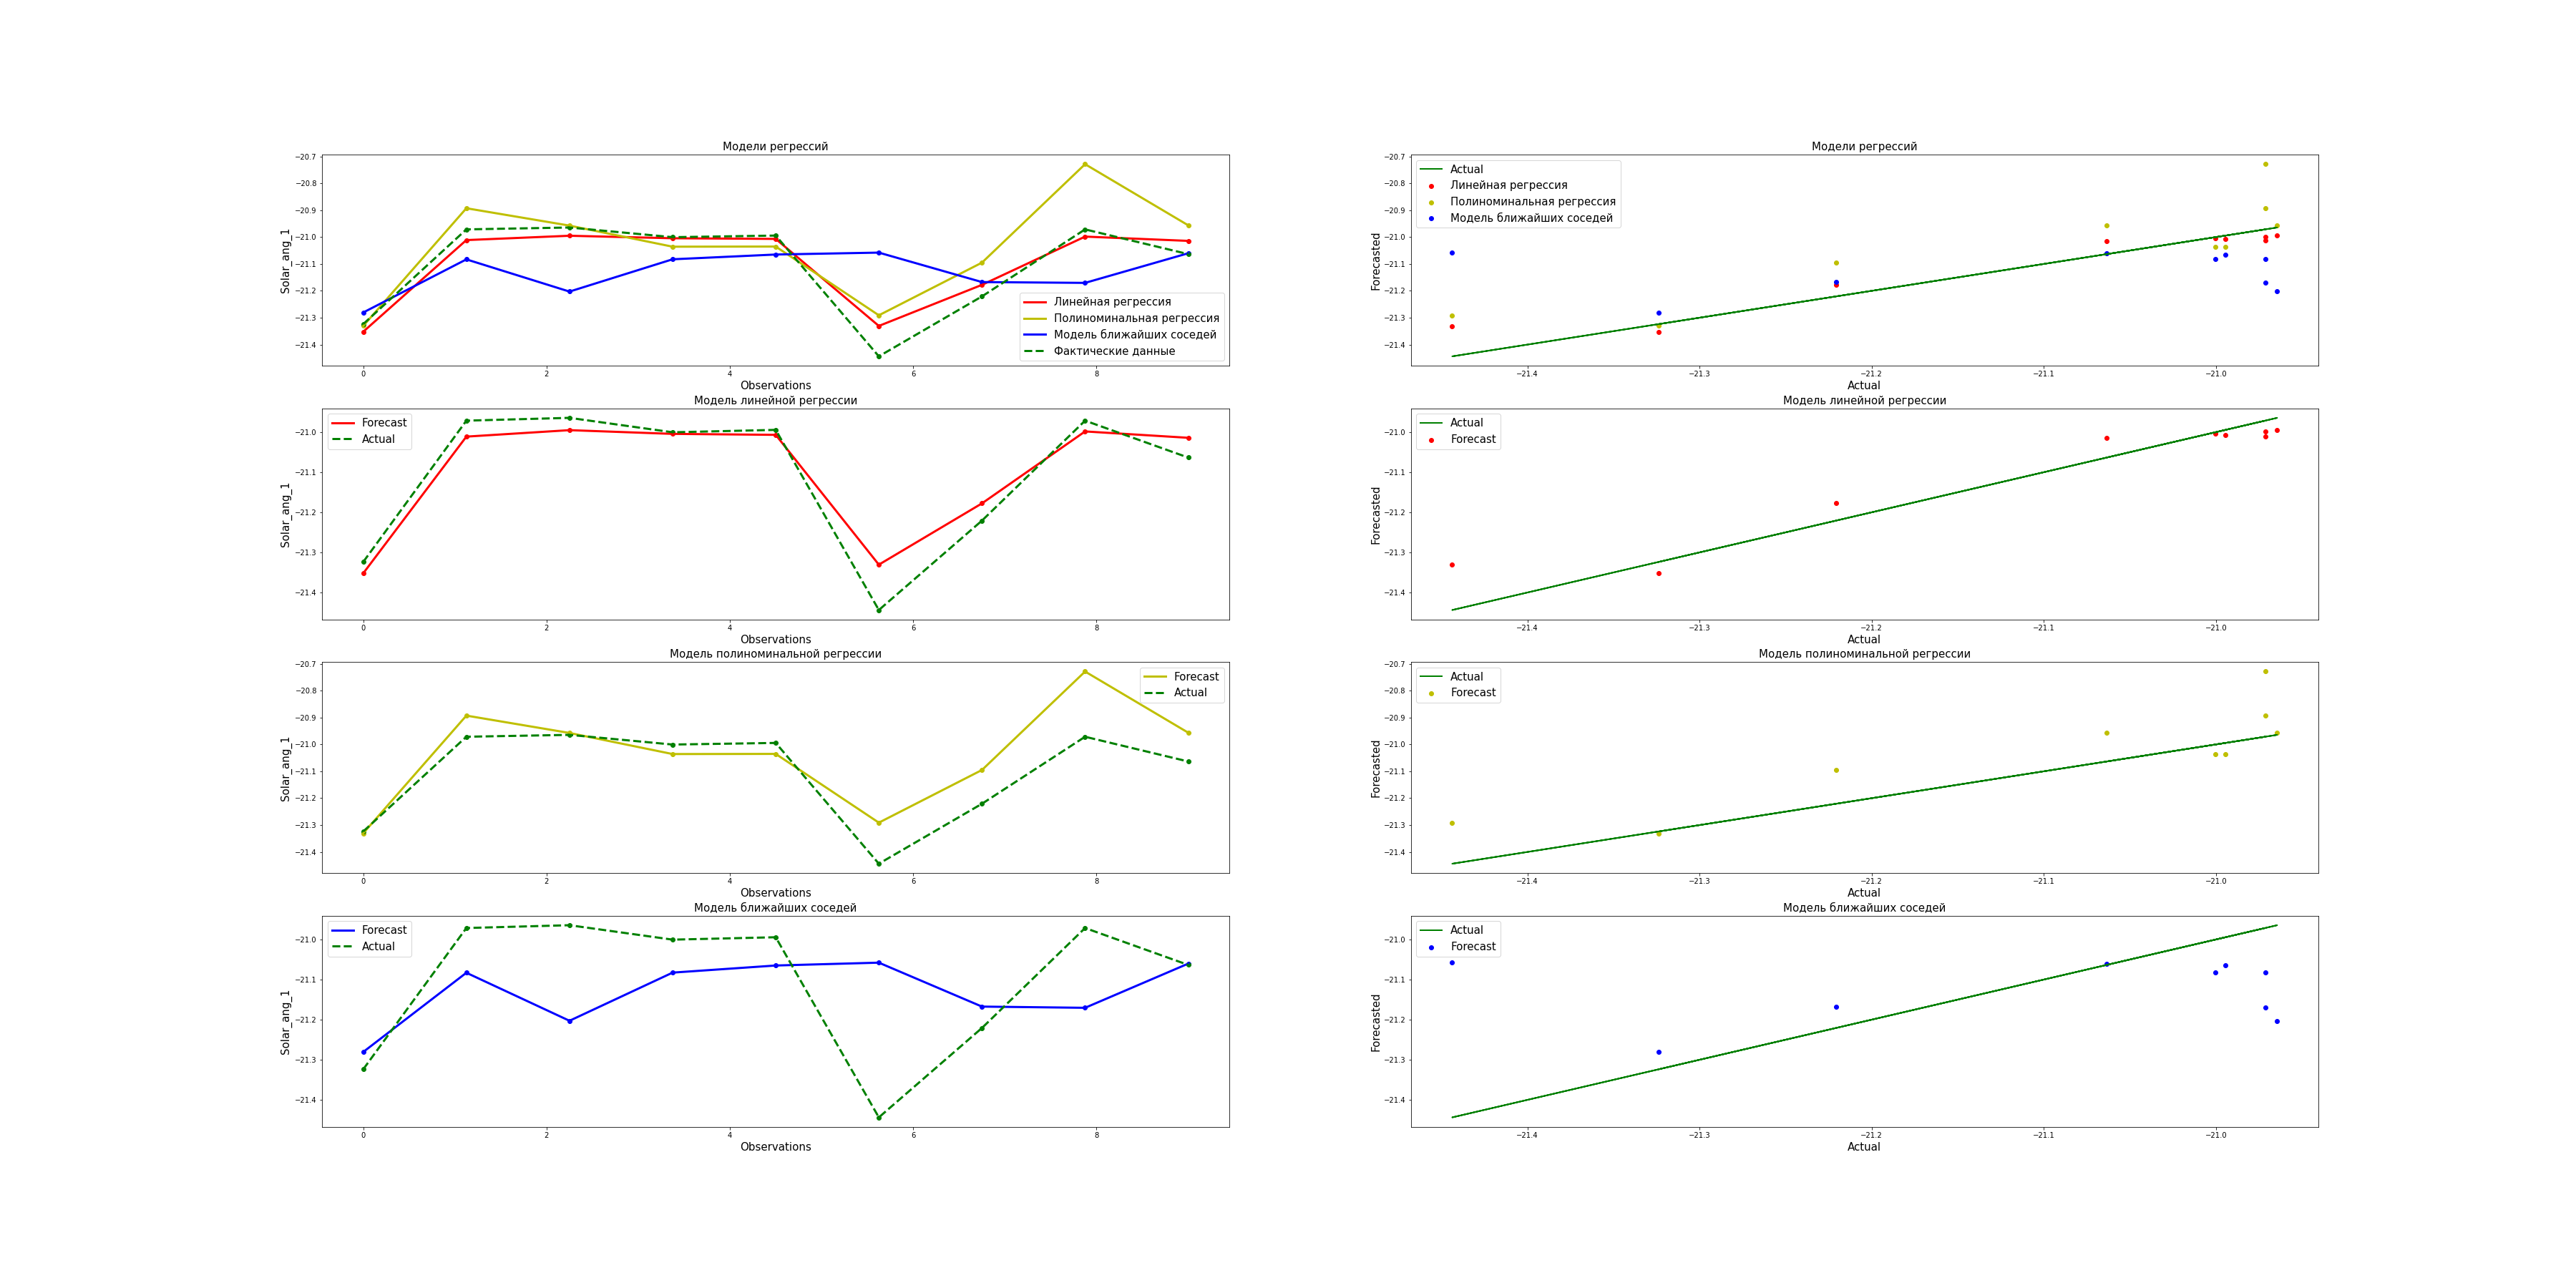

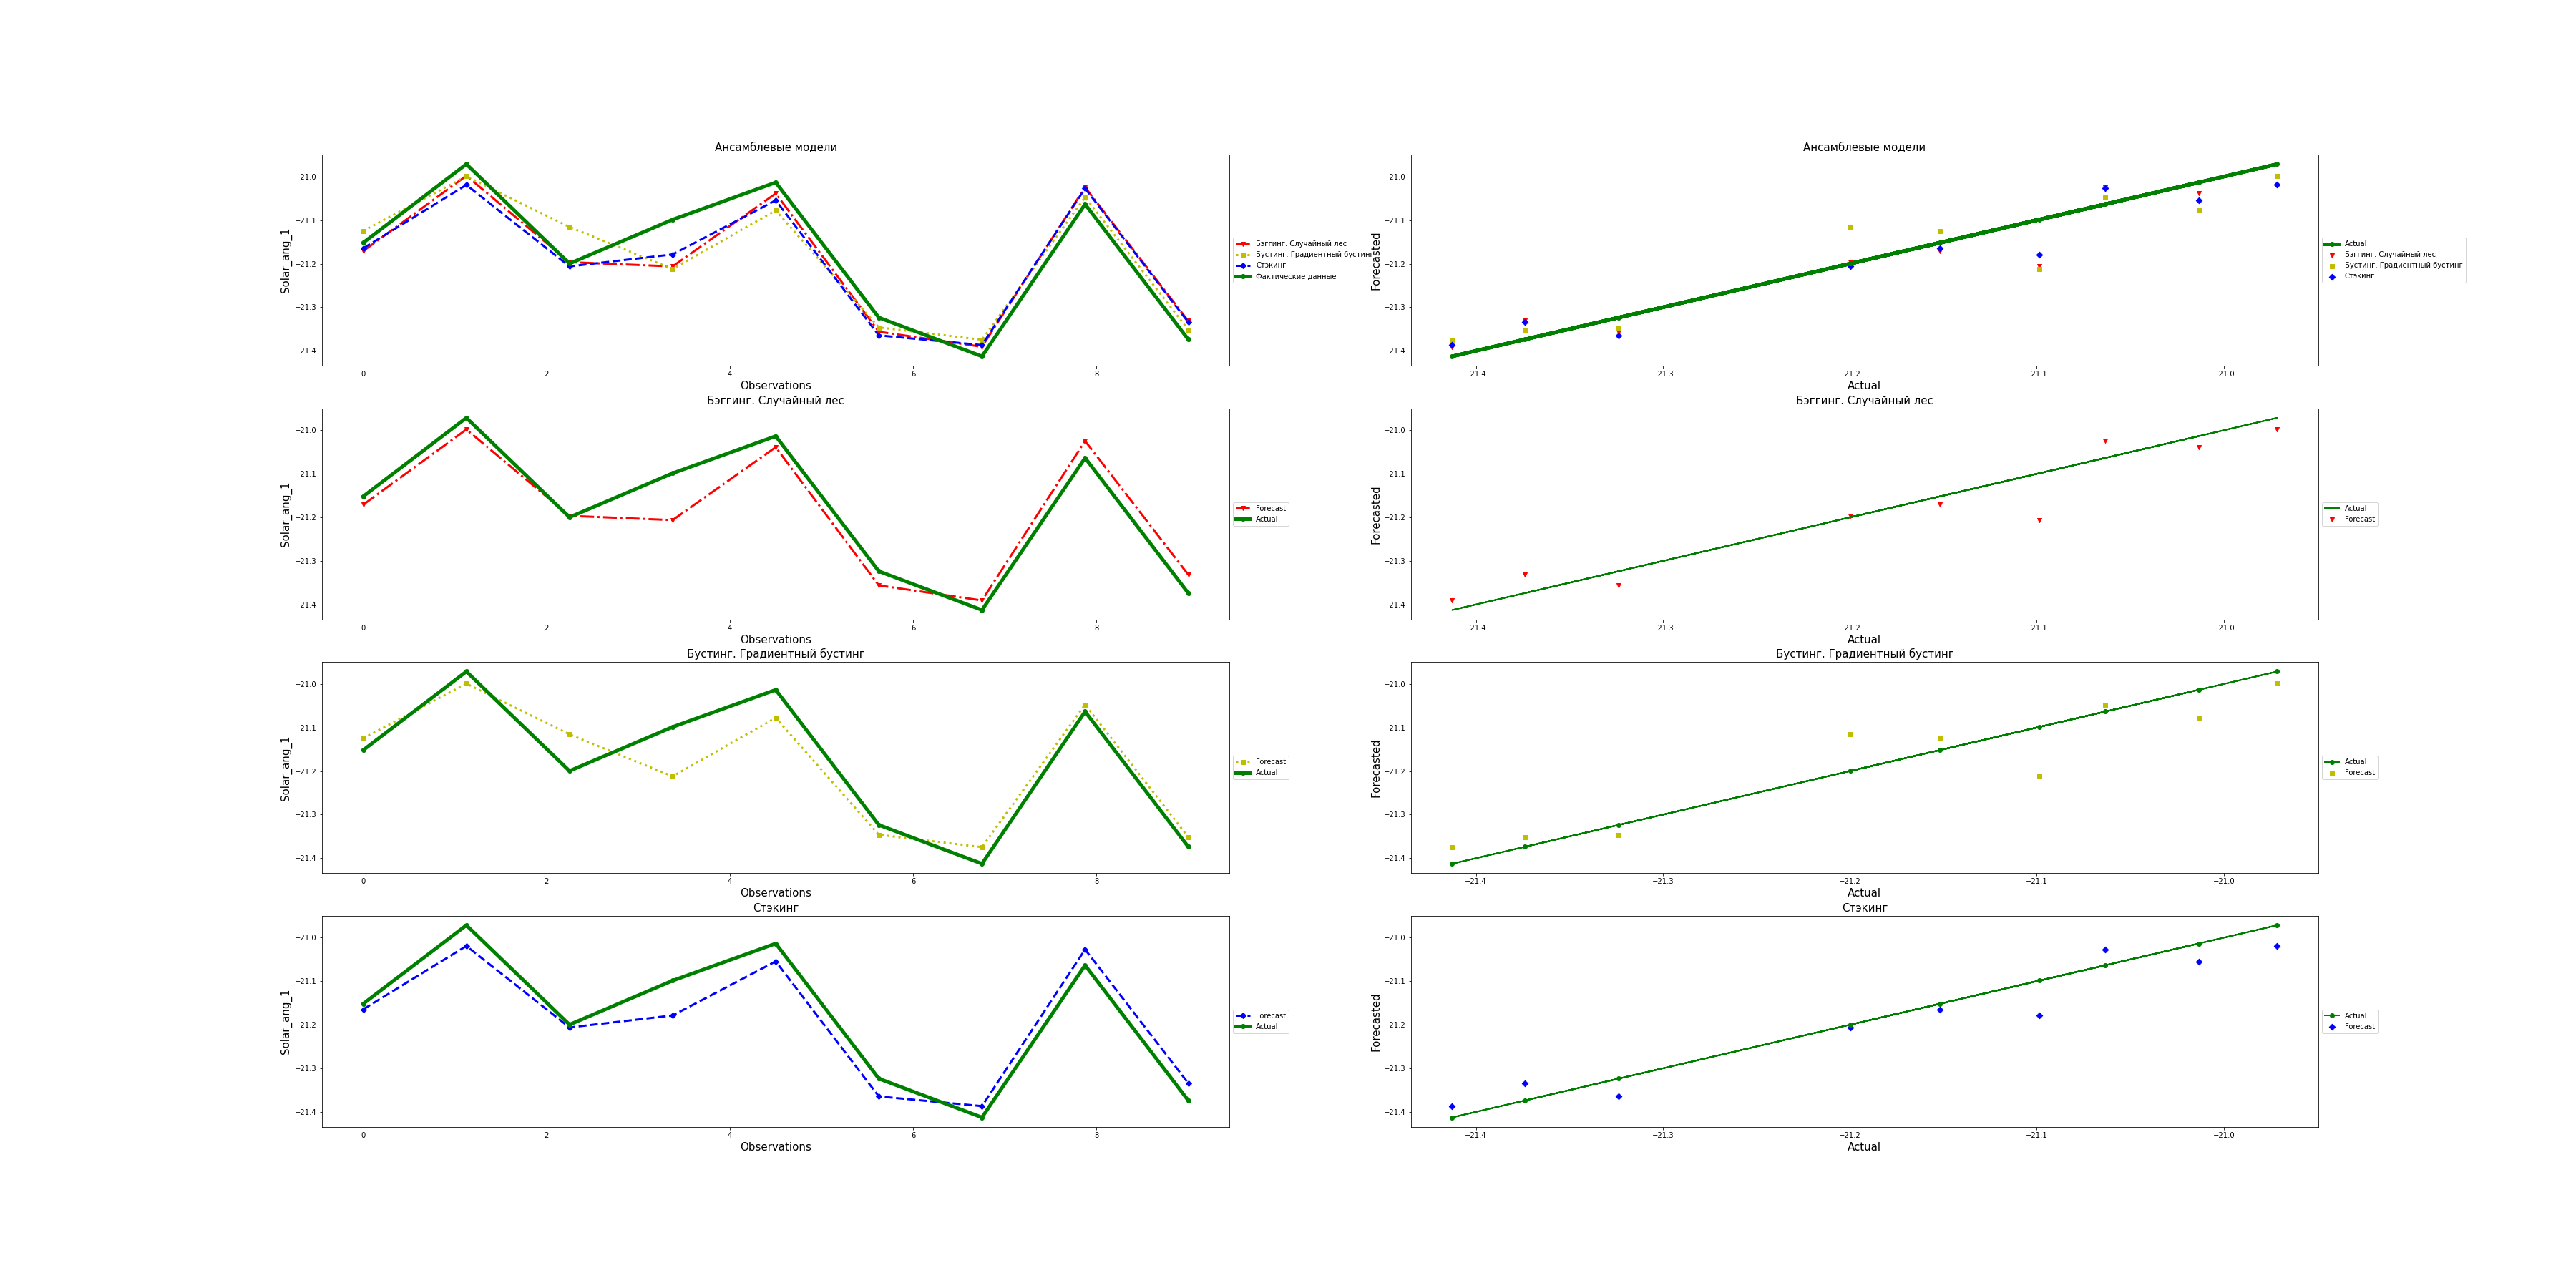

time: 37.9 ms (started: 2022-10-16 04:37:39 +00:00)


In [ ]:
display(Image('basic_reg_algorithms.png'))
display(Image('ensemble_algorithms.png'))